# Análisis exploratorio de avisos laborales y postulaciones

1. [Lectura de datos](#1. Lectura de datos)
    
2. [Análisis de los postulantes](#2. Análisis de los postulantes)

3. [Análisis de los avisos](#3. Análisis de los avisos)

4. [Análisis de las postulaciones](#4. Análisis de las postulaciones)

## 1. Lectura de datos

Contamos con seis conjuntos de datos que los leemos en sus respectivos *data frames* utilizando Pandas:

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
from itertools import cycle, islice
import geopy
from geopy.geocoders import Nominatim
import folium
from six.moves import cStringIO as StringIO
from collections import OrderedDict
from bokeh.plotting import figure, show, output_file
from math import log, sqrt

%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10,5)

In [2]:
# Postulantes
postulantes_educacion = pd.read_csv('./data/fiuba_1_postulantes_educacion.csv',\
                                    low_memory=False, encoding='utf-8')
postulantes_sexo_y_edad = pd.read_csv('./data/fiuba_2_postulantes_genero_y_edad.csv',\
                                    low_memory=False, encoding='utf-8')
# Avisos
avisos_online = pd.read_csv('./data/fiuba_5_avisos_online.csv',\
                            low_memory=False, encoding='utf-8')
avisos_detalle = pd.read_csv('./data/fiuba_6_avisos_detalle.csv',\
                             low_memory=False, encoding='utf-8')
# Transacciones
vistas = pd.read_csv('./data/fiuba_3_vistas.csv',\
                     low_memory=False, encoding='utf-8')
postulaciones = pd.read_csv('./data/fiuba_4_postulaciones.csv',\
                    low_memory=False, encoding='utf-8')

### 1.1. Datos sobre los postulantes

Tenemos dos *data frames* acerca de los postulantes: uno con información acerca de su sexo y fecha de nacimiento y el otro acerca de su nivel de educación.

In [3]:
postulantes_sexo_y_edad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200888 entries, 0 to 200887
Data columns (total 3 columns):
idpostulante       200888 non-null object
fechanacimiento    196138 non-null object
sexo               200888 non-null object
dtypes: object(3)
memory usage: 4.6+ MB


Pasamos la columna **fechanacimiento** al formato *datetime*:

In [4]:
postulantes_sexo_y_edad['fechanacimiento'] = \
    pd.to_datetime(postulantes_sexo_y_edad['fechanacimiento'], errors='coerce')

El *data frame* **postulantes_sexo_y_edad** tiene un total de 200888 registros con tres columnas:
* **idpostulante**: cadena de caracteres que representa el código de identificación del postulante
* **fechanacimiento**: año, mes y día de nacimiento del postulante separado por guiones.
* **sexo**: atributo categórico que puede tomar tres valores posibles: *FEM*, *MASC* y *NO_DECLARA*

In [5]:
postulantes_educacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298231 entries, 0 to 298230
Data columns (total 3 columns):
idpostulante    298231 non-null object
nombre          298231 non-null object
estado          298231 non-null object
dtypes: object(3)
memory usage: 6.8+ MB


El *data frame* **postulantes_educacion** tiene un total de 298231 registros con tres columnas:
* **idpostulante**: cadena de caracteres que representa el código de identificación del postulante.
* **nombre**: atributo categórico que puede tomar los siguientes valores: *Secundario*, *Terciario/Técnico*, *Universitario*, *Posgrado*, *Master*, *Doctorado* y *Otro*.
* **estado**: atributo categórico que puede tomar tres valores posibles: *En Curso*, *Graduado* y *Abandonado*

### 1.2. Datos sobre los avisos

Tenemos dos *data frames* acerca de los avisos: uno con un listado de los que se encuentraban publicados online el 8 de marzo de 2018 y otro con la información detallada de cada aviso.

In [6]:
avisos_online.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5028 entries, 0 to 5027
Data columns (total 1 columns):
idaviso    5028 non-null int64
dtypes: int64(1)
memory usage: 39.4 KB


El *data frame* **avisos_online** tiene un total de 5028 registros con una sola columna:
* **idaviso**: cadena de caracteres que representa el código de identificación del aviso.

In [7]:
avisos_detalle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13534 entries, 0 to 13533
Data columns (total 11 columns):
idaviso                 13534 non-null int64
idpais                  13534 non-null int64
titulo                  13534 non-null object
descripcion             13534 non-null object
nombre_zona             13534 non-null object
ciudad                  47 non-null object
mapacalle               872 non-null object
tipo_de_trabajo         13534 non-null object
nivel_laboral           13534 non-null object
nombre_area             13534 non-null object
denominacion_empresa    13529 non-null object
dtypes: int64(2), object(9)
memory usage: 1.1+ MB


El *data frame* **avisos_detalle** tiene un total de 13534  registros con once columnas:
* **idaviso**: cadena de caracteres que representa el código de identificación del aviso.
* **idpais**: número entero que representa el código de identificación del país del aviso.
* **titulo**: cadena de caracteres con el nombre del puesto de trabajo.
* **descripcion**: texto de varias líneas con la descripción del aviso en formato HTML.
* **nombre_zona**: cadena de caracteres que puede tener los siguientes valores: *Gran Buenos Aires*, *Capital Federal*, *GBA Oeste* y *Buenos Aires (fuera de GBA)*
* **ciudad**: cadena de caracteres con el nombre de la ciudad del puesto de trabajo.
* **mapacalle**: cadena de caracteres con la dirección del lugar de trabajo.
* **tipo_de_trabajo**: atributo categórico que puede adoptar los siguientes valores: *Full-time*, *Part-time*, *Teletrabajo*, Pasantía*, *Por Horas*, *Temporario*, *Por Contrato*, *Fines de Semana* y *Primer empleo*.
* **nivel_laboral**: atributo categórico que puede adoptar los siguientes valores: *Senior / Semi-Senior*, *Junior*, *Jefe / Supervisor / Responsable*, *Gerencia / Alta Gerencia / Dirección* y *Otro*.
* **nombre_area**: cadena de caracteres que representa el área de trabajo, como por ejemplo: *Ventas*, *Contabilidad* o *Recursos Humanos*.
* **denominacion_empresa**: nombre de la empresa que publicó el aviso.

### 1.3 Datos sobre las transacciones

Tenemos dos *data frames* con información de dos hechos a partir de las dimensiones anteriores. El *data frame* vistas contiene el detalle de todas las veces que los postulantes visualizaron los diversos avisos y el *data frame* postulaciones registra quiénes se postularon a qué avisos y cuándo.

In [8]:
vistas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961897 entries, 0 to 961896
Data columns (total 3 columns):
idAviso         961897 non-null int64
timestamp       961897 non-null object
idpostulante    961897 non-null object
dtypes: int64(1), object(2)
memory usage: 22.0+ MB


El *data frame* **vistas** tiene un total de 961897 registros con tres columnas:
* **idAviso**: cadena de caracteres que representa el código de identificación del aviso visto.
* **timestamp**: año, mes día y hora exacta en la que se produjo la vista del aviso.
* **idpostulante**: cadena de caracteres que representa el código de identificación del postulante que vio el aviso.

In [9]:
postulaciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3401623 entries, 0 to 3401622
Data columns (total 3 columns):
idaviso             int64
idpostulante        object
fechapostulacion    object
dtypes: int64(1), object(2)
memory usage: 77.9+ MB


El *data frame* **postulaciones** tiene un total de 3401623 registros con tres columnas:
* **idaviso**: cadena de caracteres que representa el código de identificación del aviso al cual se realizó la postulación.
* **idpostulante**: cadena de caracteres que representa el código de identificación del postulante.
* **fechapostulacion**: año, mes día y hora exacta en la que se produjo la postulación.

Pasamos las columnas de fechas al formato *datetime*:

In [10]:
vistas['timestamp'] = pd.to_datetime(vistas['timestamp'], errors = 'coerce')
postulaciones['fechapostulacion'] = \
    pd.to_datetime(postulaciones['fechapostulacion'], errors = 'coerce')

## 2. Análisis de los postulantes

In [11]:
def categorizar_sexo(x):
    if((x is np.nan) | (x == 'NO_DECLARA')):
        return 'No declara'
    if(x == 'FEM'):
        return 'Femenino'
    if(x == 'MASC'):
        return 'Masculino'
postulantes_sexo_y_edad['sexo'] = postulantes_sexo_y_edad['sexo']\
    .apply(lambda x: categorizar_sexo(x))
postulantes_sexo_y_edad.groupby('sexo').count()

,idpostulante,fechanacimiento
sexo,,
Femenino,101981,101674
Masculino,94339,94013
No declara,4568,444


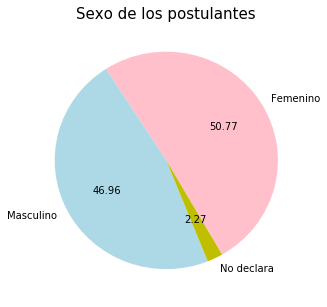

In [12]:
sexo = postulantes_sexo_y_edad['sexo'].value_counts()
plt = sexo.plot.pie(fontsize = 10, figsize = (5, 5), startangle = 300, autopct = '%.2f',
              title = 'Sexo de los postulantes', colors = ['pink','lightblue','y']);
plt.set_title('Sexo de los postulantes', fontsize = 15);
plt.axis('off');

### Edades de los postulantes

In [13]:
def calcular_edad(fecha_nacimiento):
    hoy = datetime.date.today()
    return hoy.year - fecha_nacimiento.year - \
        ((hoy.month, hoy.day) < (fecha_nacimiento.month, fecha_nacimiento.day))

postulantes_sexo_y_edad['edad'] = postulantes_sexo_y_edad['fechanacimiento']\
    .apply(lambda x: calcular_edad(x))
postulantes_sexo_y_edad['edad'] = postulantes_sexo_y_edad['edad']\
    .fillna(0.0).astype(int)

In [14]:
sexo_edad = postulantes_sexo_y_edad.loc[((postulantes_sexo_y_edad['edad'] <= 65)\
    & (postulantes_sexo_y_edad['edad'] >= 16) & (postulantes_sexo_y_edad['sexo']\
    != 'No declara')),:].groupby(['edad','sexo']).count().reset_index()\
    .pivot(index = 'edad', columns = 'sexo', values = 'idpostulante')

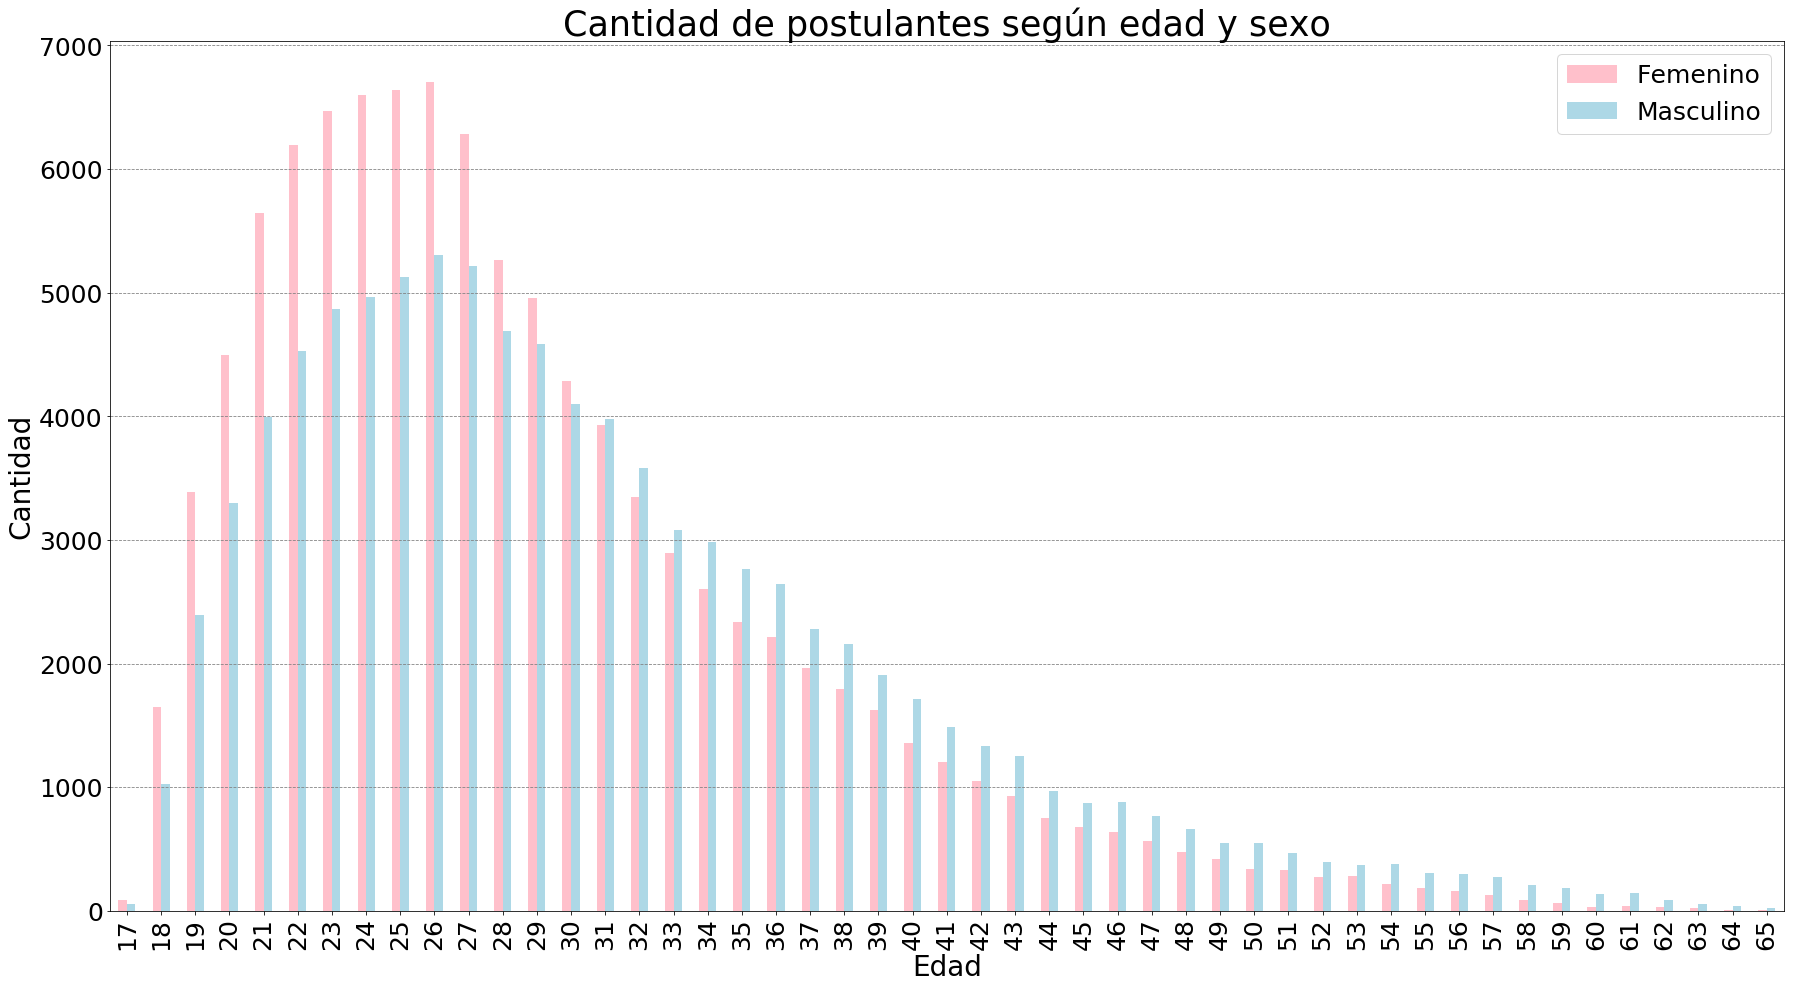

In [15]:
plt = sexo_edad.plot(kind = 'bar',color = ['pink','lightblue'],\
    figsize = (30, 16), fontsize = 25)
plt.set_xlabel('Edad', fontsize = 28)
plt.set_ylabel('Cantidad', fontsize = 28)
plt.set_title('Cantidad de postulantes según edad y sexo', fontsize = 35)
plt.grid(linestyle = 'dashed', color= 'gray')
plt.legend(fontsize = 25)
plt.xaxis.grid(False);

En el gráfico se puede apreciar que hay más postulantes mujeres que varones hasta los 30 años de edad y a partir de los 31 es al revés. Además podemos ver que la mayor cantidad de postulantes en general son jóvenes, entre 20 y 30 años.

### Nivel de estudios alcanzados por sexo y por edad

Agregamos una nueva columna para categorizar el nivel de estudios alcanzado en donde ponemos a 'Posgrado', 'Master' y 'Doctorado' en la categoría 'Posgrado' e ignoramos por ahora el estado:

In [16]:
def categorizar_estudios(x):
    if((x is np.nan) | (x == 'Otro')):
        return 0
    if(x == 'Secundario'):
        return 1
    if(x == 'Terciario/Técnico'):
        return 2
    if(x == 'Universitario'):
        return 3
    if((x == 'Posgrado') | (x == 'Master') | (x == 'Doctorado')):
        return 4

postulantes_educacion['nivel_alcanzado'] = postulantes_educacion['nombre']\
    .apply(lambda x: categorizar_estudios(x))
postulantes_educacion.head()

,idpostulante,nombre,estado,nivel_alcanzado
0,NdJl,Posgrado,En Curso,4
1,8BkL,Universitario,En Curso,3
2,1d2B,Universitario,En Curso,3
3,NPBx,Universitario,En Curso,3
4,NPBx,Master,En Curso,4


Unimos ambos *data frames* de los postulantes:

In [17]:
postulantes = pd.merge(postulantes_sexo_y_edad, postulantes_educacion,\
    on='idpostulante', how='outer')
postulantes.head()

,idpostulante,fechanacimiento,sexo,edad,nombre,estado,nivel_alcanzado
0,NM5M,1970-12-03,Femenino,47,Secundario,Graduado,1.0
1,5awk,1962-12-04,Femenino,55,Universitario,Graduado,3.0
2,5awk,1962-12-04,Femenino,55,Terciario/Técnico,Graduado,2.0
3,ZaO5,1978-08-10,Femenino,39,Terciario/Técnico,Graduado,2.0
4,ZaO5,1978-08-10,Femenino,39,Universitario,Abandonado,3.0


Ignoraremos por ahora el estado de los estudios y nos quedamos únicamente con el nivel más alto, independientemente de si lo haya finalizado o no.

In [18]:
postulantes = postulantes.sort_values('nivel_alcanzado', ascending = False)\
    .drop_duplicates('idpostulante')

In [19]:
nivel_sexo = postulantes.groupby(['sexo', 'nivel_alcanzado']).count().reset_index()\
    .drop(['fechanacimiento', 'nombre', 'estado'], axis = 1)\
    .pivot(index = 'nivel_alcanzado', columns = 'sexo', values = 'idpostulante')
nivel_sexo

sexo,Femenino,Masculino,No declara
nivel_alcanzado,,,
0.0,579,731,28
1.0,28060,33162,1189
2.0,15593,11480,356
3.0,48298,38455,1085
4.0,4473,5188,75


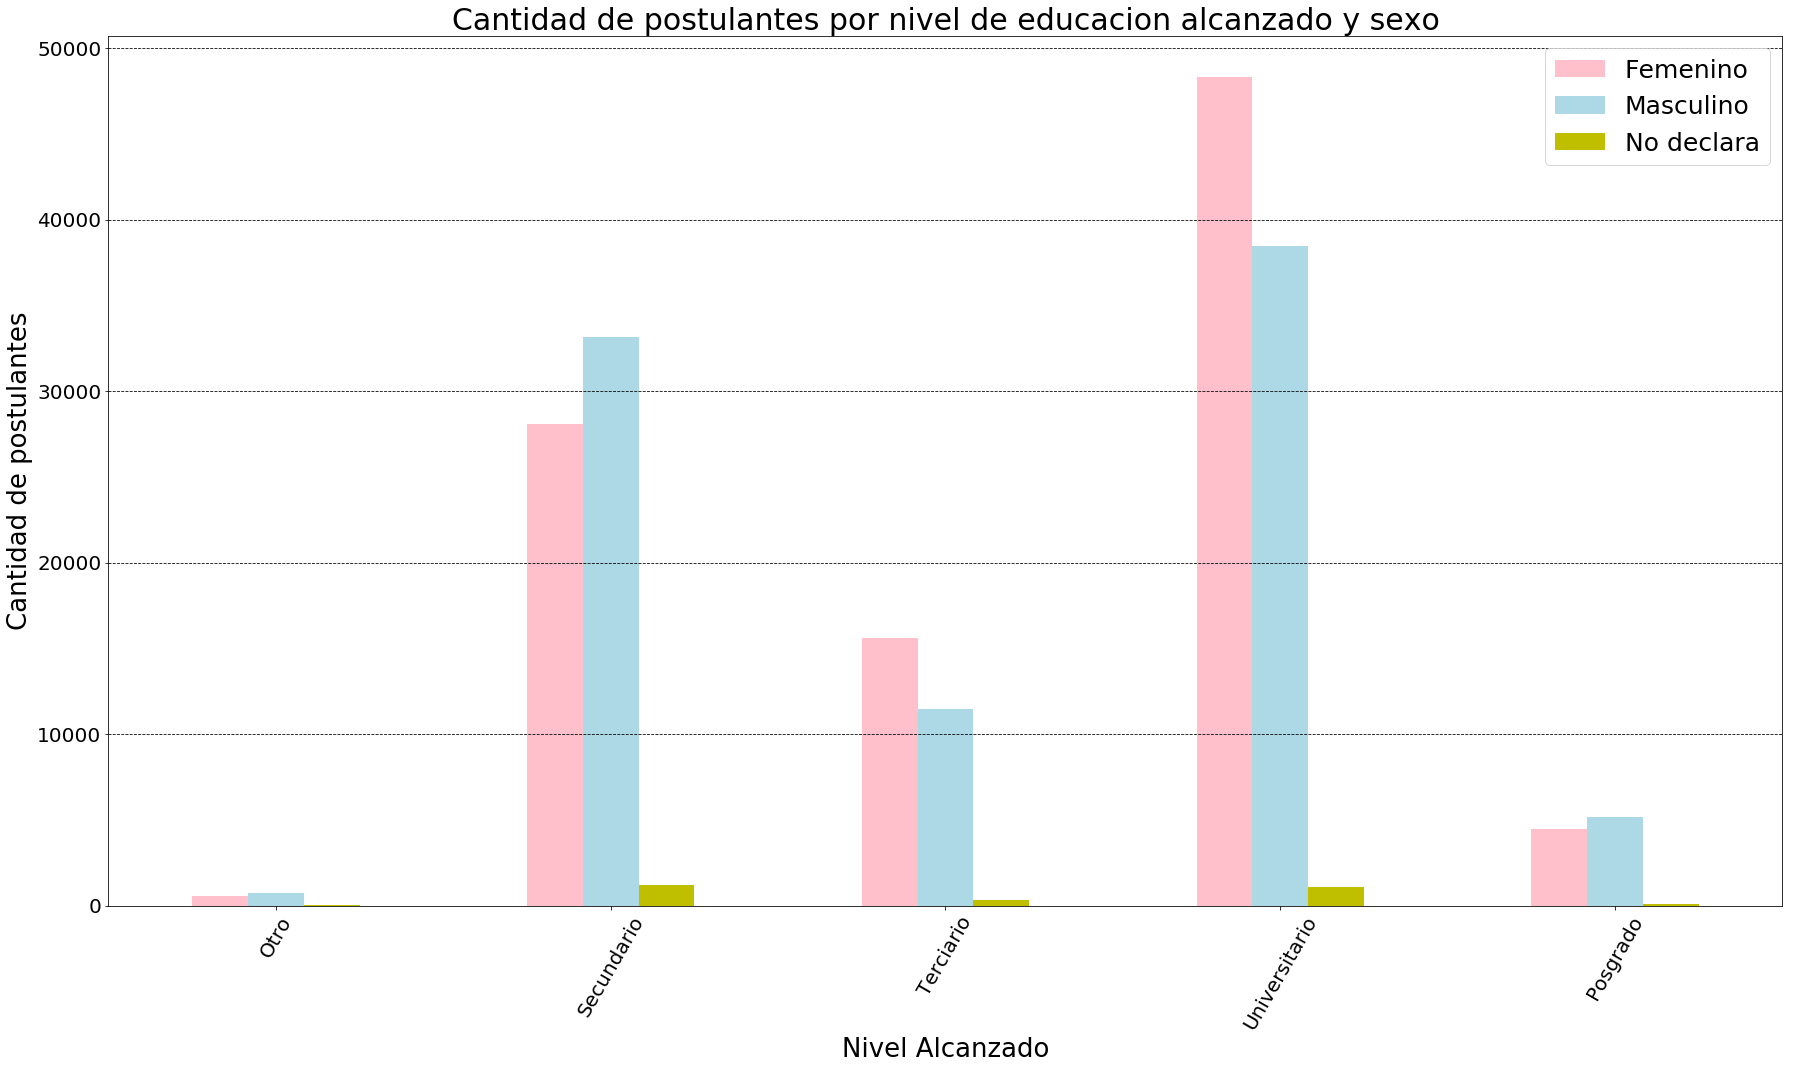

In [20]:
plt = nivel_sexo.plot(kind = 'bar', color = ['pink','lightblue','y'],\
    figsize=(30,16), rot=60)
plt.set_xlabel('Nivel Alcanzado', fontsize = 26)
plt.set_ylabel('Cantidad de postulantes', fontsize = 26)
plt.set_title('Cantidad de postulantes por nivel de educacion alcanzado y sexo',\
    fontsize = 30)
plt.set_xticklabels(('Otro', 'Secundario','Terciario','Universitario','Posgrado'),\
    fontsize = 20)
plt.set_yticklabels((0, 10000, 20000, 30000, 40000, 50000), fontsize = 20)
plt.grid(linestyle = 'dashed', color = 'black')
plt.legend(fontsize = 25)
plt.xaxis.grid(False);

In [21]:
def categorizar_edad(x):
    if (x <= 21):
        return '21 o menos'
    if (x <= 26):
        return '22 a 26'
    if (x <= 30):
        return '27 a 30'
    if (x <= 35):
        return '31 a 35'
    if (x <= 40):
        return '36 a 40'
    if (x <= 50):
        return '41 a 50'
    return '51 o más'

postulantes['rango_edad'] = postulantes['edad'].apply(lambda x: categorizar_edad(x))

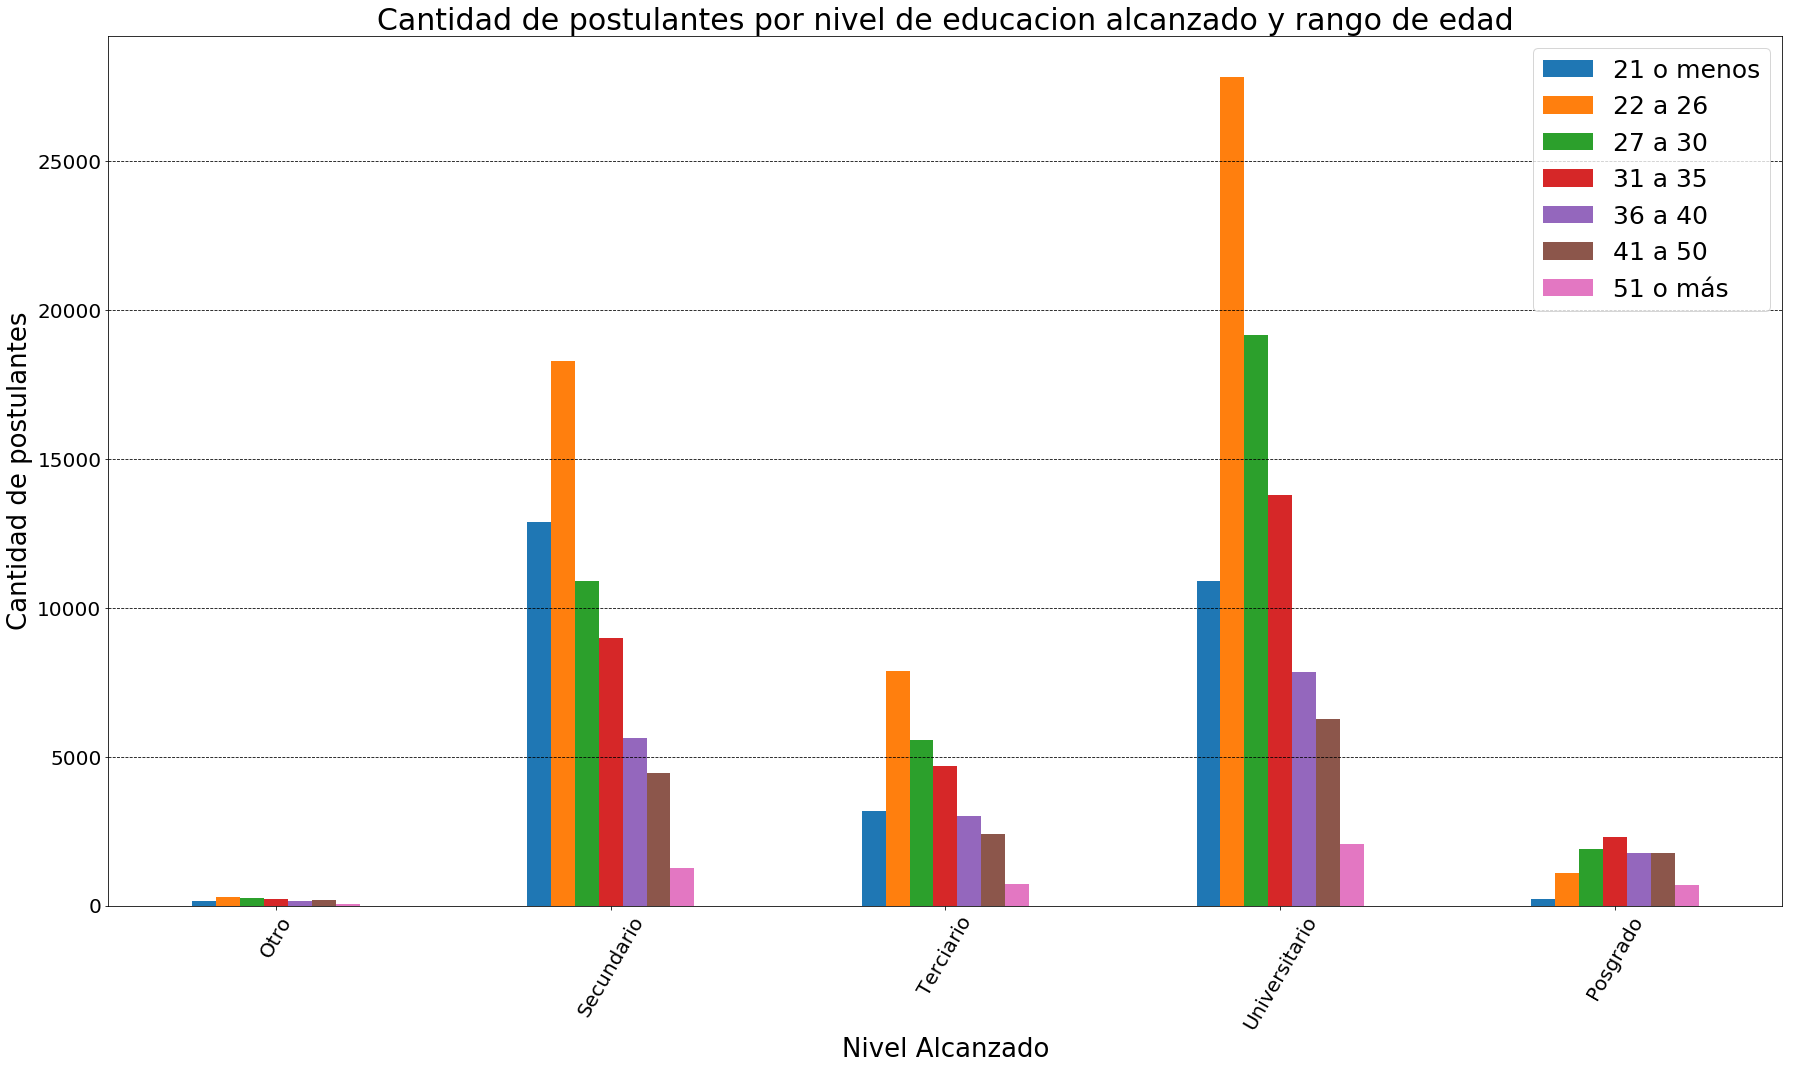

In [22]:
plt = postulantes.groupby(['nivel_alcanzado','rango_edad']).size().\
    to_frame('cant').reset_index().pivot(index = 'nivel_alcanzado',\
                            columns = 'rango_edad', values = 'cant')\
    .plot(kind = 'bar', figsize = (30, 16), rot = 60)
plt.set_xlabel('Nivel Alcanzado', fontsize = 26)
plt.set_ylabel('Cantidad de postulantes', fontsize = 26)
plt.set_title('Cantidad de postulantes por nivel de educacion alcanzado y rango de edad',\
    fontsize = 30)
plt.set_xticklabels(('Otro', 'Secundario','Terciario','Universitario','Posgrado'),\
    fontsize = 20)
plt.set_yticklabels((0, 5000, 10000, 15000, 20000, 25000), fontsize = 20)
plt.legend(fontsize = 25)
plt.grid(linestyle = 'dashed', color = 'black')
plt.xaxis.grid(False);

## 3. Análisis de los avisos

### Ubicación geográfica de las empresas

In [23]:
avisos_detalle.groupby(['nombre_zona','ciudad']).size()

nombre_zona        ciudad                  
Capital Federal    Buenos Aires                2 
                   CABA                        1 
                   Microcentro                 1 
Gran Buenos Aires  Argentina                   13
                   Barracas                    1 
                   Buenos Aires                12
                   Buenos Aires Province       1 
                   CABA                        2 
                   Capital Federal             2 
                   La Plata                    1 
                   Mendoza                     1 
                   Parque Patricios            1 
                   República Argentina         1 
                   San Isidro                  2 
                   Santa Rosa                  1 
                   Tortuguitas                 1 
                   Vicente Lopez               1 
                   Zárate, Campana, Escobar    1 
                   caba                        1 
      

Muy pocos registros tienen información en las columnas *nombre_zona* y *ciudad* y solamente figuran Capital Federal y Gran Buenos Aires, por lo que es necesario procesar las direcciones de la columna *mapacalle*.
Para ello corregimos primero algunas palabras mal escritas y le agregamos a todas "Buenos Aires Argentina" al final para que sea más fácil encontrar su ubicación.

In [24]:
def corregir_direcciones(direccion):
    if direccion is not pd.np.nan:
        direccion = direccion.replace("Pres.", "Presidente")
        direccion = direccion.replace("moteagudo", "Monteagudo")
        direccion = direccion.replace("Belgarno", "Belgrano")
        direccion = direccion.replace("Av", "Avenida")
        direccion = direccion.replace("nro", "")
        direccion = direccion.replace("Gdor.", "Gobernador")
        direccion = direccion.replace("piso", "")
        direccion = direccion.replace("Piso", "")
        direccion = direccion.replace("Int", "Intendente")
        direccion = direccion + " Buenos Aires Argentina"
    return direccion

avisos_detalle['mapacalle'] = avisos_detalle['mapacalle']\
    .apply(lambda x: corregir_direcciones(x))

In [25]:
direcciones = avisos_detalle.groupby(['denominacion_empresa','mapacalle'])\
    .count().reset_index()
direcciones.drop(['idaviso','idpais','titulo','descripcion','nombre_zona','ciudad',\
    'tipo_de_trabajo','nivel_laboral','nombre_area'], axis = 1, inplace = True)

direcciones.head()

,denominacion_empresa,mapacalle
0,A. E. Ponce Ingeniería S.A.,OLAZABAL 1515 Buenos Aires Argentina
1,ACCIONA IT,Barracas Buenos Aires Argentina
2,ACCIONA IT,Paysandú 1800 Buenos Aires Argentina
3,ADEPCON,Sánchez de Loria 2395 Buenos Aires Argentina
4,ADHEFULL SA,Superí 2100 Buenos Aires Argentina


Mediante la biblioteca GeoPy buscamos la latitud y longitud de cada una de las direcciones de la columna *mapacalle* después de haber sido procesada para luego poder ubicarlos como markers en el mapa mediante Folium.

In [ ]:
from geopy.exc import GeocoderTimedOut
def obtener_coordenadas(direccion):
    geolocator = Nominatim(timeout=None)
    try:
        lugar = geolocator.geocode(direccion)
    except GeocoderTimedOut as e:
        lugar = None
    return False if lugar is None else [lugar.latitude, lugar.longitude]

direcciones['coordenadas'] = direcciones['mapacalle']\
    .apply(lambda x: obtener_coordenadas(x))
direcciones.head()

In [ ]:
map = folium.Map(location=[-34.617, -58.44], zoom_start=11)
for coord in direcciones.coordenadas:
    if (coord):
        folium.RegularPolygonMarker(coord, radius=6, number_of_sides=9).add_to(map)
map

![Mapa](./mapa.png)

Si bien hay muchos registros que no indican dirección y que no los podemos ubicar en el mapa, con los que sí se pudo podemos apreciar cómo la mayoría se concentran en el microcentro porteño y en la zona norte de la ciudad.

### Empresas y áreas de trabajo con más avisos

In [28]:
top15_empresas = avisos_detalle.groupby('denominacion_empresa').size()\
    .sort_values(ascending=False).head(15).to_frame('cantidad').reset_index()

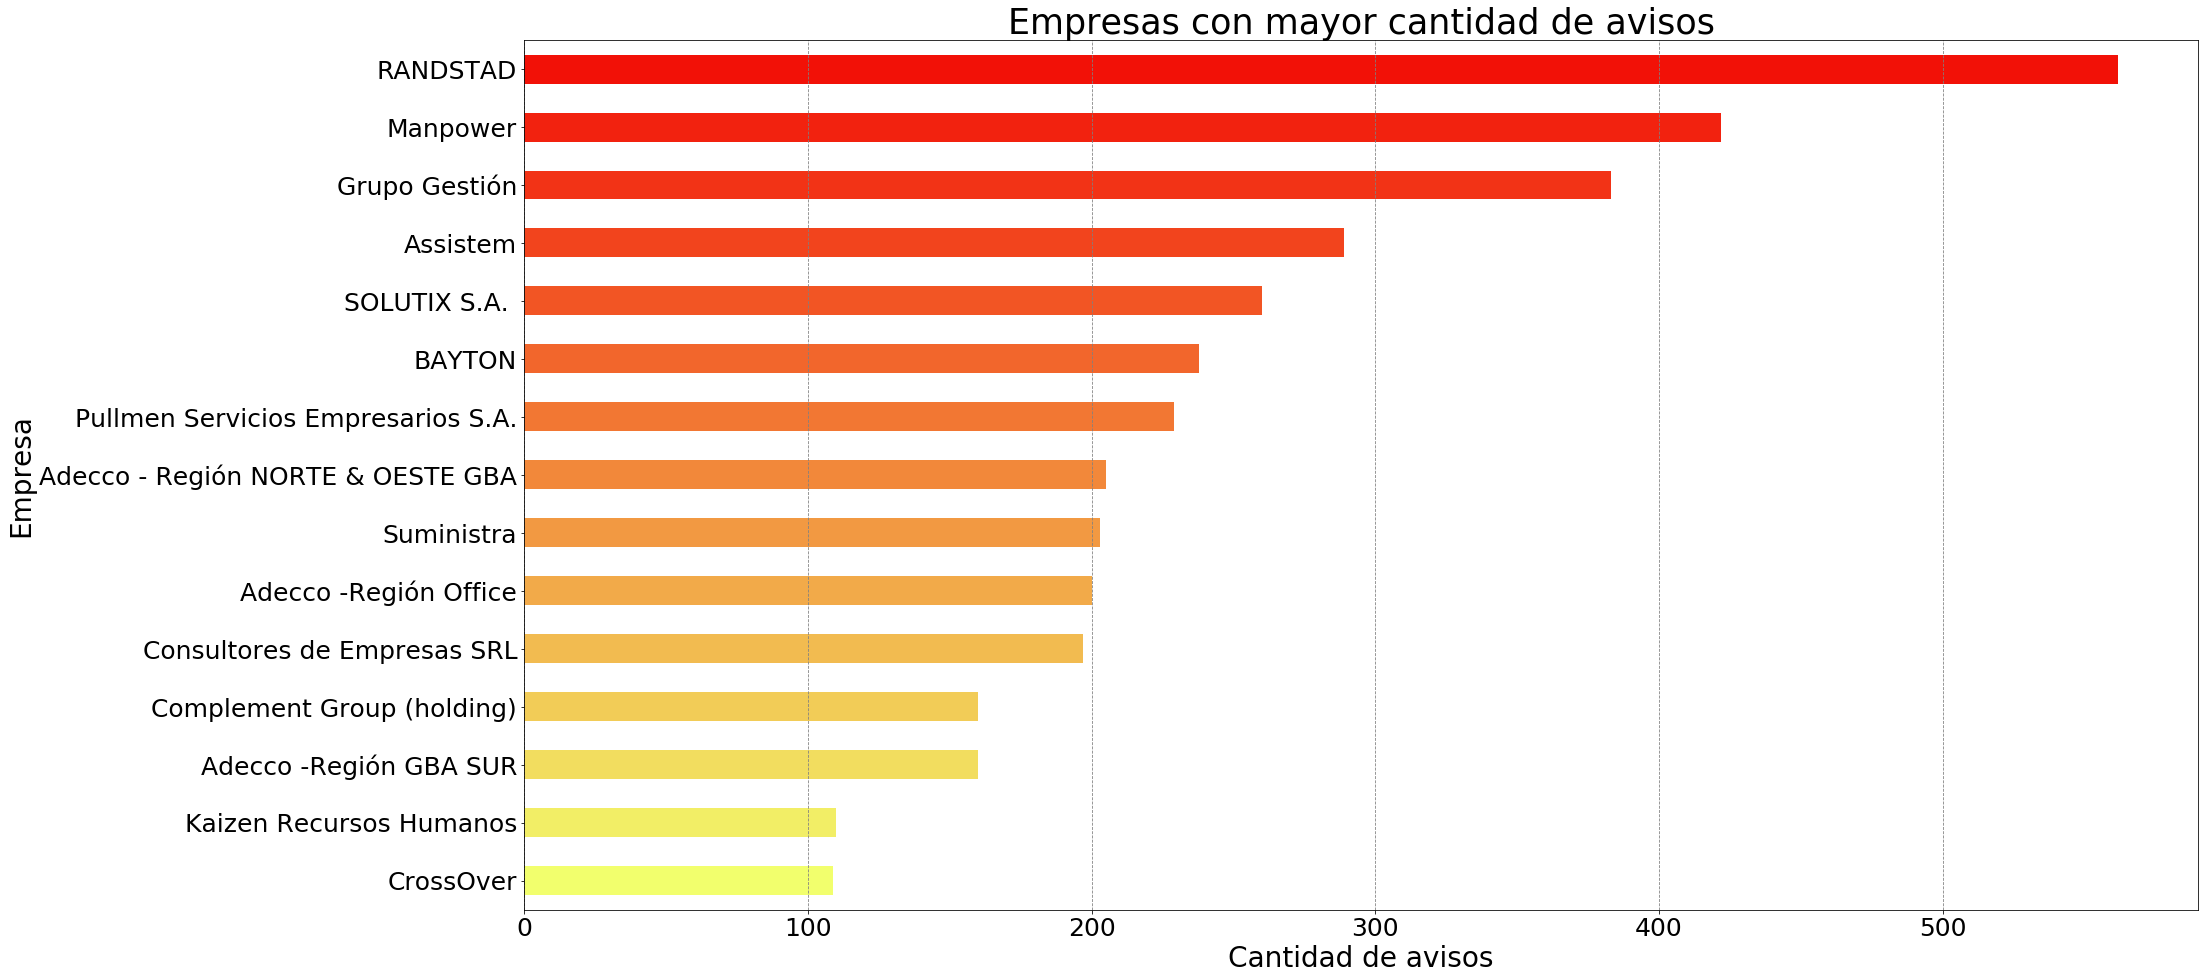

In [29]:
colorsh = []
i = 15
while i != 0:
    colorsh.append((0.95, (i*2)/30.0, i/35.0))
    i -= 1

plt = top15_empresas.set_index('denominacion_empresa').sort_values(by = 'cantidad')
plt = plt['cantidad'].plot(kind = 'barh', color = colorsh,\
    figsize = (30, 16), fontsize = 25)
plt.set_xlabel('Cantidad de avisos', fontsize = 28)
plt.set_ylabel('Empresa', fontsize = 28)
plt.set_title('Empresas con mayor cantidad de avisos', fontsize = 35)
plt.grid(linestyle = 'dashed', color = 'gray')
plt.yaxis.grid(False);

In [30]:
top15_areas = avisos_detalle.groupby('nombre_area').size()\
    .sort_values(ascending=False).head(15).to_frame('cantidad').reset_index()

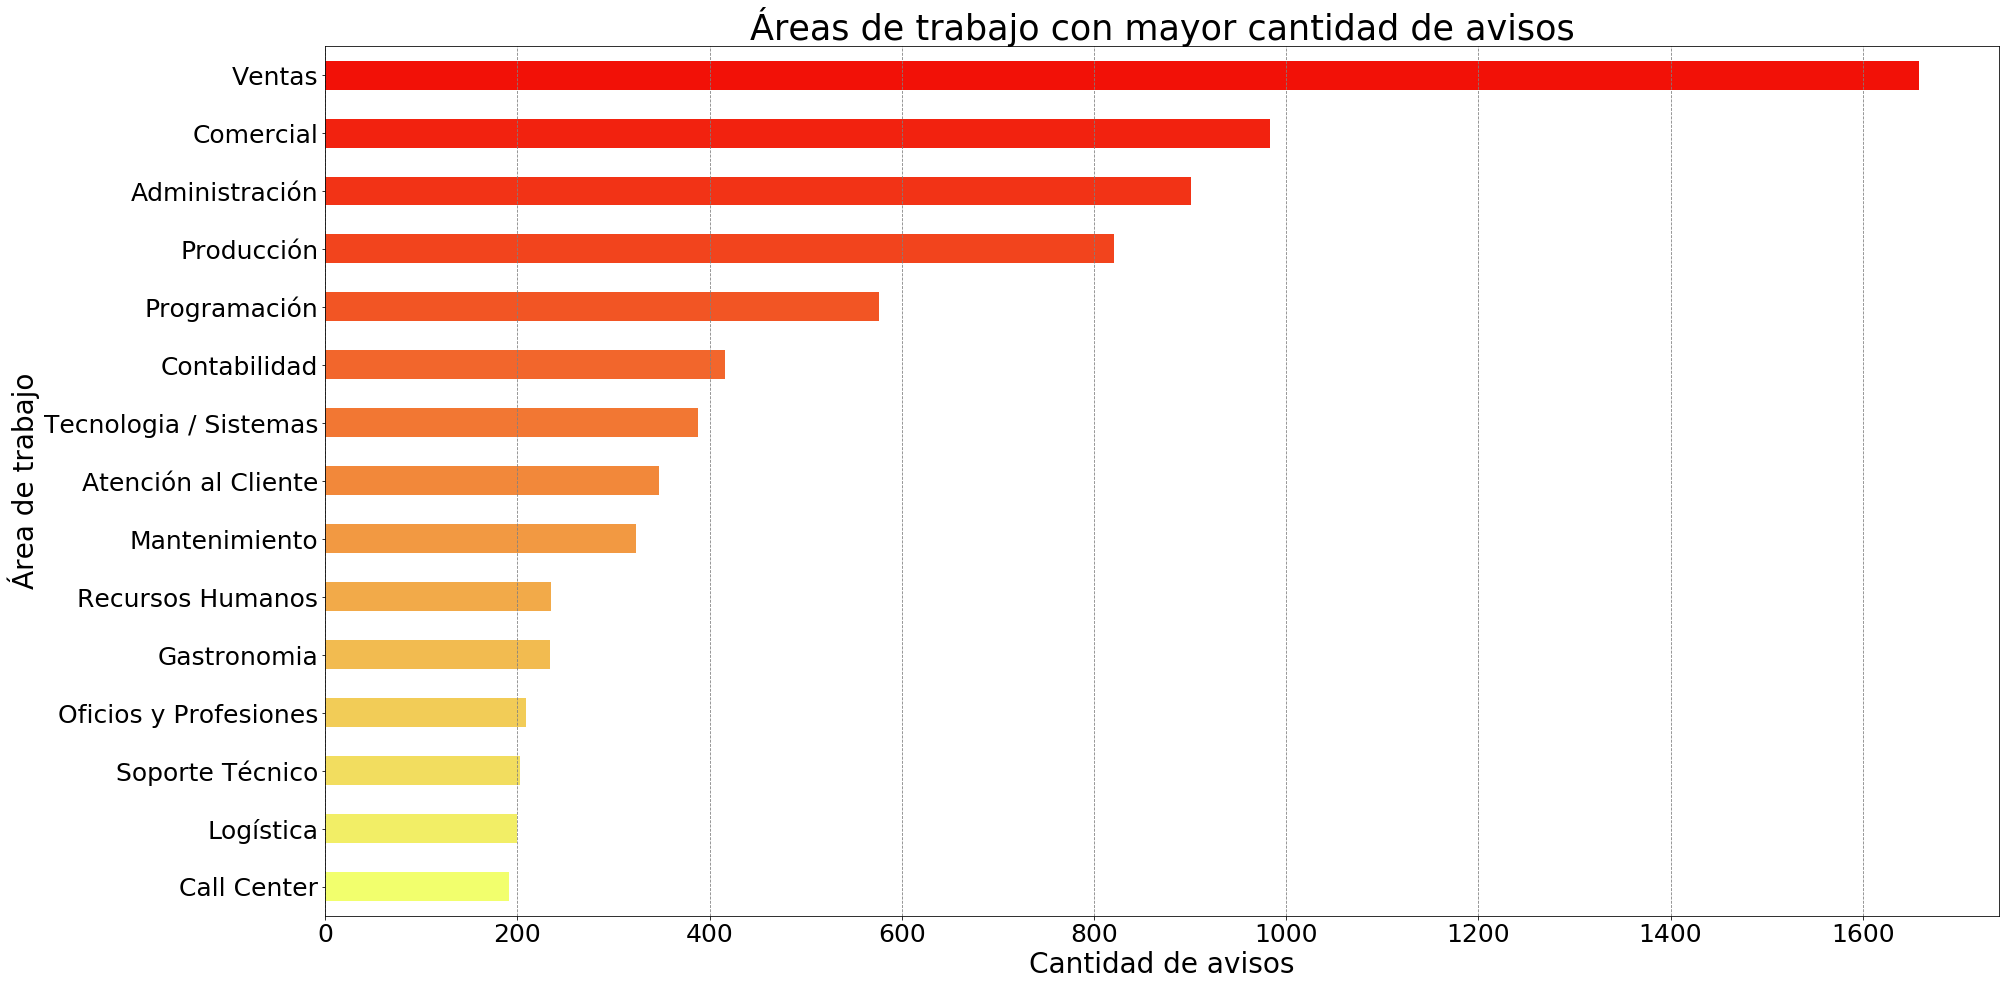

In [31]:
plt = top15_areas.set_index('nombre_area').sort_values(by = 'cantidad')
plt = plt['cantidad'].plot(kind = 'barh', color = colorsh,\
    figsize = (30, 16), fontsize = 25)
plt.set_xlabel('Cantidad de avisos', fontsize = 28)
plt.set_ylabel('Área de trabajo', fontsize = 28)
plt.set_title('Áreas de trabajo con mayor cantidad de avisos', fontsize = 35)
plt.grid(linestyle='dashed', color = 'gray')
plt.yaxis.grid(False);

### Áreas de trabajo de las empresas con más avisos

Tomaremos las quince áreas más frecuentes entre las 15 empresas con mayor cantidad de avisos:

In [32]:
top15_areas_e = pd.merge(top15_empresas, avisos_detalle, how = 'inner',\
    on = 'denominacion_empresa').groupby('nombre_area').size()\
    .sort_values(ascending=False).head(15).to_frame('cantidad').reset_index()

In [33]:
areas_empresas = pd.merge(top15_empresas, avisos_detalle, how = 'inner',\
                          on = 'denominacion_empresa')
areas_empresas = pd.merge(top15_areas_e, areas_empresas, how='inner',\
                          on = 'nombre_area')
areas_empresas.rename(index = str, columns = {"denominacion_empresa": "Empresa",\
                            "nombre_area": "Área de trabajo"}, inplace = True)
areas_empresas = areas_empresas.groupby(['Empresa', 'Área de trabajo'])\
    .count().reset_index().pivot(index='Empresa', columns = 'Área de trabajo',\
                                 values = 'cantidad_x')
areas_empresas.fillna(0, inplace = True)

Excluiremos a la empresa SOLUTIX de la visualización porque tiene la gran mayoría de sus postulaciones en el área de programación y muy pocas en las demás áreas.

In [34]:
areas_empresas = areas_empresas.reset_index()
areas_empresas = areas_empresas.loc[areas_empresas.Empresa.str.contains('SOLUTIX') == False,:]\
    .set_index('Empresa')

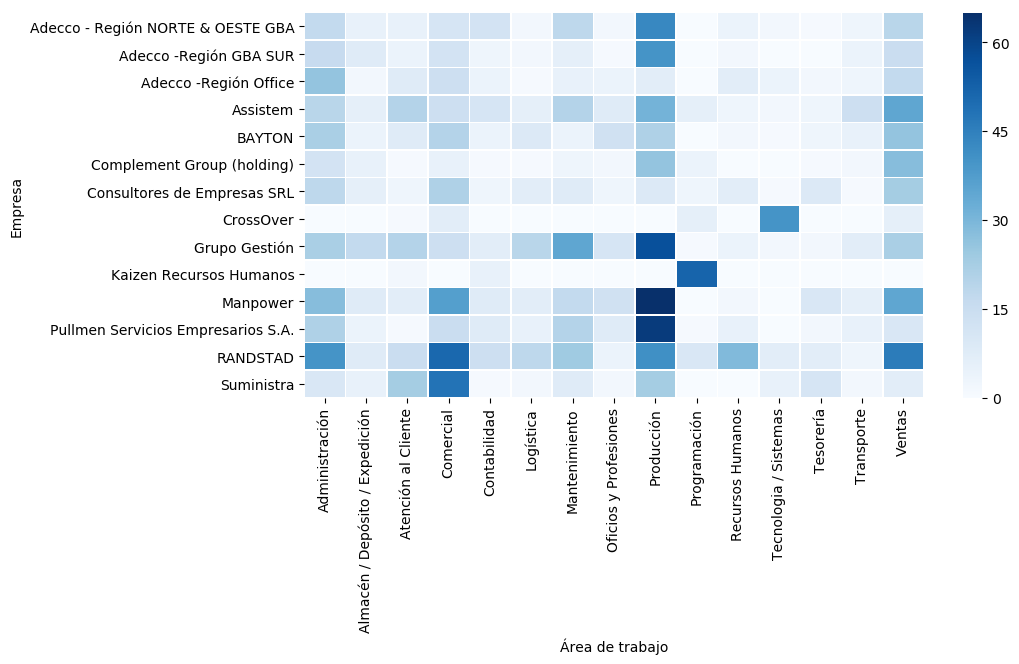

In [38]:
sns.heatmap(areas_empresas, annot=False, linewidths=.5, cmap='Blues');

De estas últimas tres visualizaciones podemos ver que el área de ventas es la que más avisos tiene pero distribuidos en diversas empresas. En cambio el área de producción, que figura cuarta en cantidad de postulaciones en general, es la que más avisos tiene entre las empresas con más avisos.
Además se puede apreciar cómo empresas consultoras de trabajo como Randstad y Manpower presentan avisos en una gran variedad de áreas.

## 4. Análisis de las vistas y postulaciones

### Cantidad de postulaciones por día de la semana y sexo

In [ ]:
postulaciones['dia'] = postulaciones['fechapostulacion'].dt.weekday.map(\
                        pd.Series('0 1 2 3 4 5 6'.split()))
postulaciones['dia'] = postulaciones.dia.apply(pd.to_numeric)
postulaciones['mes'] = postulaciones['fechapostulacion'].dt.month
postulaciones['semana'] = postulaciones['fechapostulacion'].dt.weekofyear
postulaciones.head()

In [196]:
postulaciones_merged = pd.merge(postulaciones, postulantes, how = 'inner', on = 'idpostulante')
postulaciones_merged = postulaciones_merged.groupby(['dia', 'sexo']).size().to_frame('cantidad').reset_index()
postulaciones_merged = postulaciones_merged.pivot(index = 'dia', columns = 'sexo', values = 'cantidad')
postulaciones_merged.reset_index(inplace = True)

In [197]:
postulaciones_merged.sort_values(by = 'dia', ascending = False, inplace = True)
postulaciones_merged['dia'] = postulaciones_merged['dia']\
    .map(pd.Series('Lunes Martes Miércoles Jueves Viernes Sábado Domingo'.split()))
postulaciones_merged = postulaciones_merged.set_index('dia')

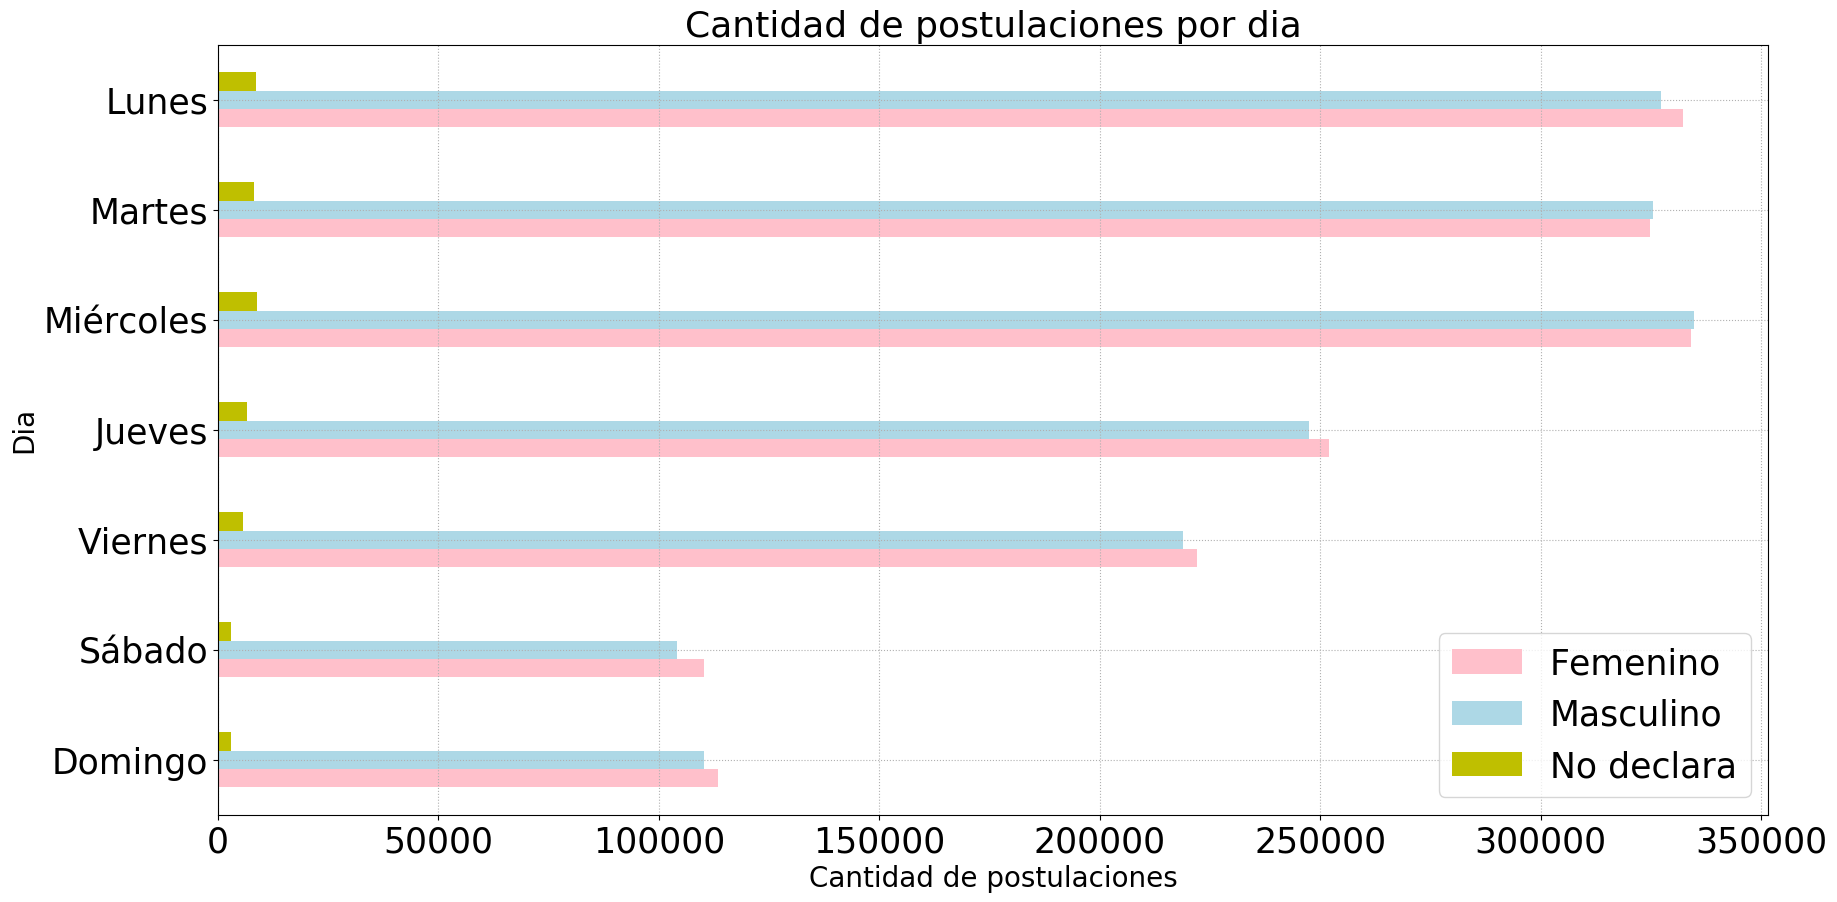

In [202]:
plot = postulaciones_merged.plot(kind = 'barh'\
    , figsize = (20,10), fontsize = 25, color = ['pink', 'lightblue', 'y'])
plot.set_title('Cantidad de postulaciones por dia', fontsize = 26)
plot.set_xlabel('Cantidad de postulaciones', fontsize = 20)
plot.set_ylabel('Dia', fontsize = 20)
plot.legend(fontsize = 25)
plot.grid(linestyle='dotted');

Los días de la semana con mayor cantidad de postulaciones en general son los lunes, martes y miércoles. Los martes y miércoles son los únicos días en los que hay más postulantes varones que mujeres (por muy poca diferencia).

#### Comparación de cantidades de vistas y postulaciones por día de la semana

In [205]:
vistas['dia'] = vistas['timestamp'].dt.weekday.map(\
                        pd.Series('0 1 2 3 4 5 6'.split()))
vistas['dia'] = vistas.dia.apply(pd.to_numeric)
vistas['mes'] = vistas['timestamp'].dt.month
vistas['semana'] = vistas['timestamp'].dt.weekofyear
vistas.head()

,idAviso,timestamp,idpostulante,dia,mes,semana
0,1111780242,2018-02-23 18:38:13.187,YjVJQ6Z,4,2,8
1,1112263876,2018-02-23 18:38:14.296,BmVpYoR,4,2,8
2,1112327963,2018-02-23 18:38:14.329,wVkBzZd,4,2,8
3,1112318643,2018-02-23 18:38:17.921,OqmP9pv,4,2,8
4,1111903673,2018-02-23 18:38:18.973,DrpbXDP,4,2,8


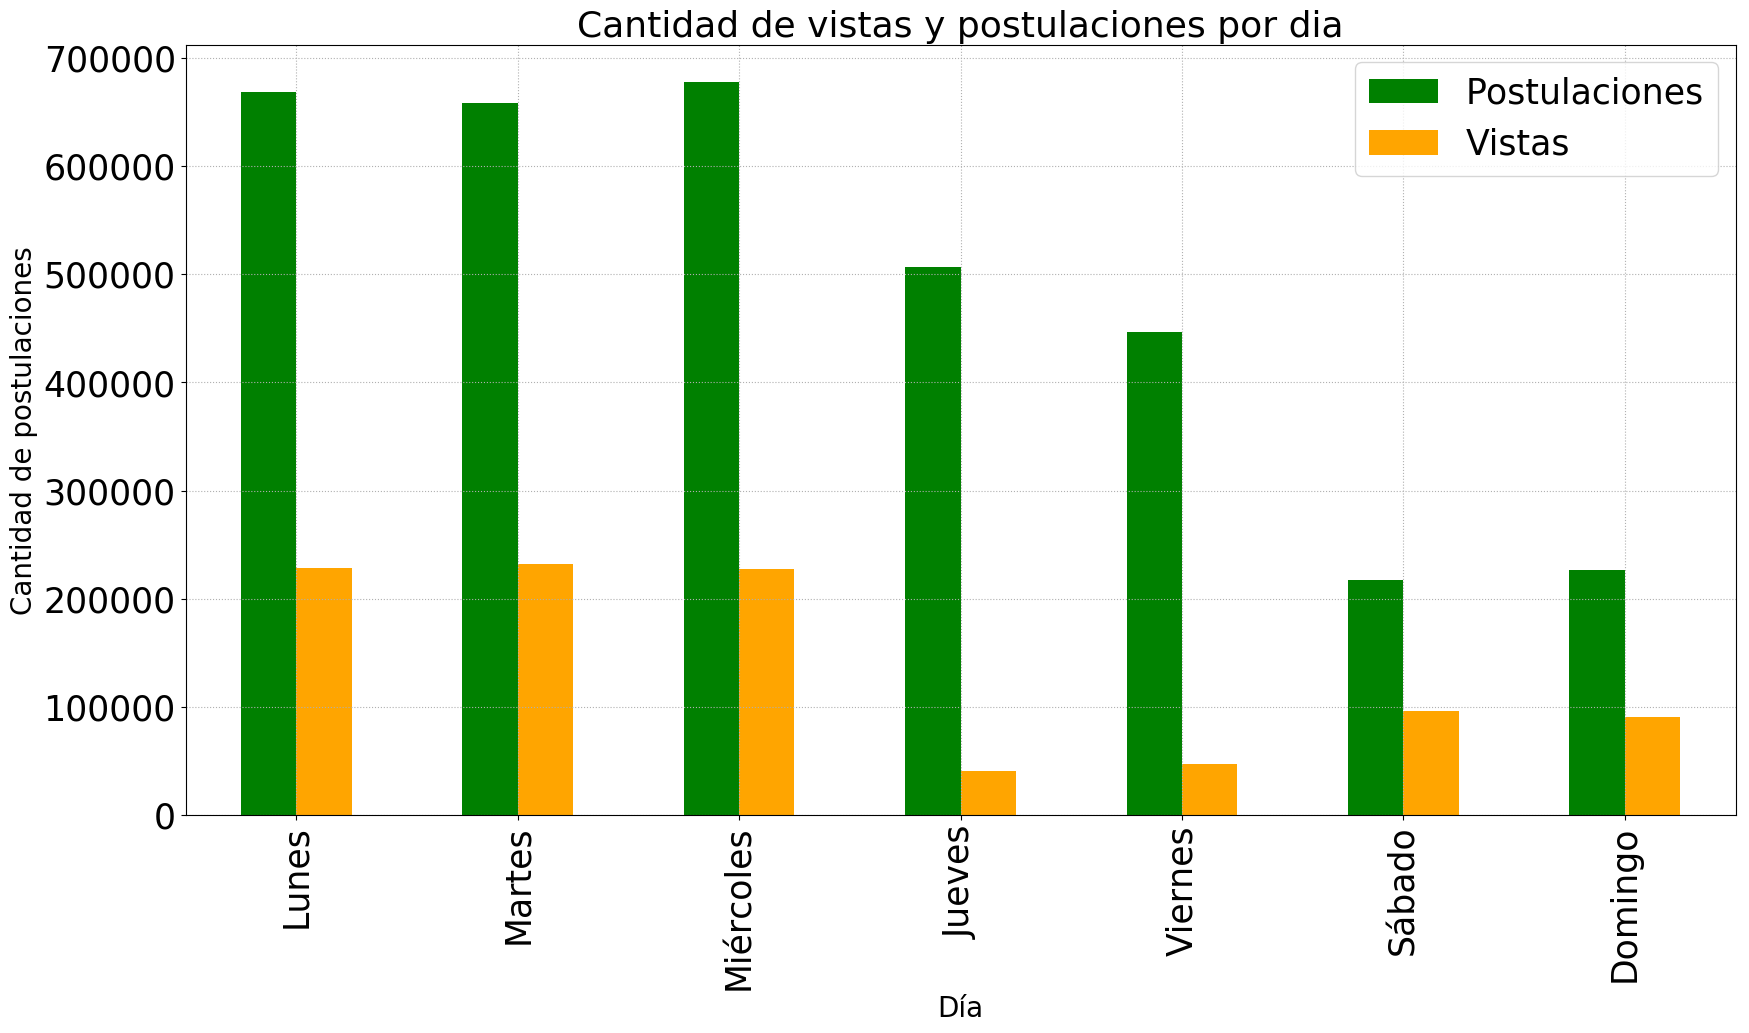

In [228]:
vistas['Operacion'] = 'Vistas'
postulaciones['Operacion'] = 'Postulaciones'
vis_pos = pd.concat([vistas, postulaciones])

vis_pos = vis_pos.groupby(['dia', 'Operacion']).size().to_frame('Cantidad').reset_index()\
    .pivot(index = 'dia', columns = 'Operacion', values = 'Cantidad')

vis_pos = vis_pos.reset_index()
vis_pos['dia'] = vis_pos['dia']\
    .map(pd.Series('Lunes Martes Miércoles Jueves Viernes Sábado Domingo'.split())) 
vis_pos = vis_pos.set_index('dia')

plot = vis_pos.plot.bar(figsize = (20,10), fontsize = 25, color = ['g','orange'])
plot.set_title('Cantidad de vistas y postulaciones por dia', fontsize = 26)
plot.set_ylabel('Cantidad de postulaciones', fontsize = 20)
plot.set_xlabel('Día', fontsize = 20)
plot.legend(fontsize = 25)
plot.grid(linestyle='dotted');

Las mayores cantidades de vistas se producen de lunes a miércoles, al igual que las postulaciones. Sin embargo, los sábados y domingos se realizan más vistas que los jueves y viernes, al revés que como sucede con las postulaciones.

Hay muchas más postulaciones que vistas y no tenemos registros de las vistas anónimas. Suponiendo que antes de postularse se debe primero ver un aviso se concluye que la mayoría de los usuarios ven los avisos primero y se loguean recién al momento de postularse.

### Rangos horarios con más vistas

In [48]:
vistas['hora'] = vistas['timestamp'].dt.hour
vistas.head()

,idAviso,timestamp,idpostulante,hora
0,1111780242,2018-02-23 18:38:13.187,YjVJQ6Z,18
1,1112263876,2018-02-23 18:38:14.296,BmVpYoR,18
2,1112327963,2018-02-23 18:38:14.329,wVkBzZd,18
3,1112318643,2018-02-23 18:38:17.921,OqmP9pv,18
4,1111903673,2018-02-23 18:38:18.973,DrpbXDP,18


In [49]:
vistas.rename(index=str, columns={"idAviso": "idaviso"}, inplace=True)
#vis_avi = pd.merge(vistas, avisos_detalle, on='idaviso', how='inner')
vis_avi = pd.merge(vistas,postulantes,on = 'idpostulante',how='inner')
vis_avi.head()

,idaviso,timestamp,idpostulante,hora,fechanacimiento,sexo,edad,nombre,estado,nivel_alcanzado,rango_edad
0,1111780242,2018-02-23 18:38:13.187,YjVJQ6Z,18,1991-11-16,Masculino,26,Universitario,Abandonado,3.0,22 a 26
1,1112301574,2018-02-27 16:28:37.162,YjVJQ6Z,16,1991-11-16,Masculino,26,Universitario,Abandonado,3.0,22 a 26
2,1112319451,2018-02-27 16:26:31.101,YjVJQ6Z,16,1991-11-16,Masculino,26,Universitario,Abandonado,3.0,22 a 26
3,1112326950,2018-02-27 16:28:43.417,YjVJQ6Z,16,1991-11-16,Masculino,26,Universitario,Abandonado,3.0,22 a 26
4,1112263876,2018-02-23 18:38:14.296,BmVpYoR,18,1989-12-08,Masculino,28,Universitario,En Curso,3.0,27 a 30


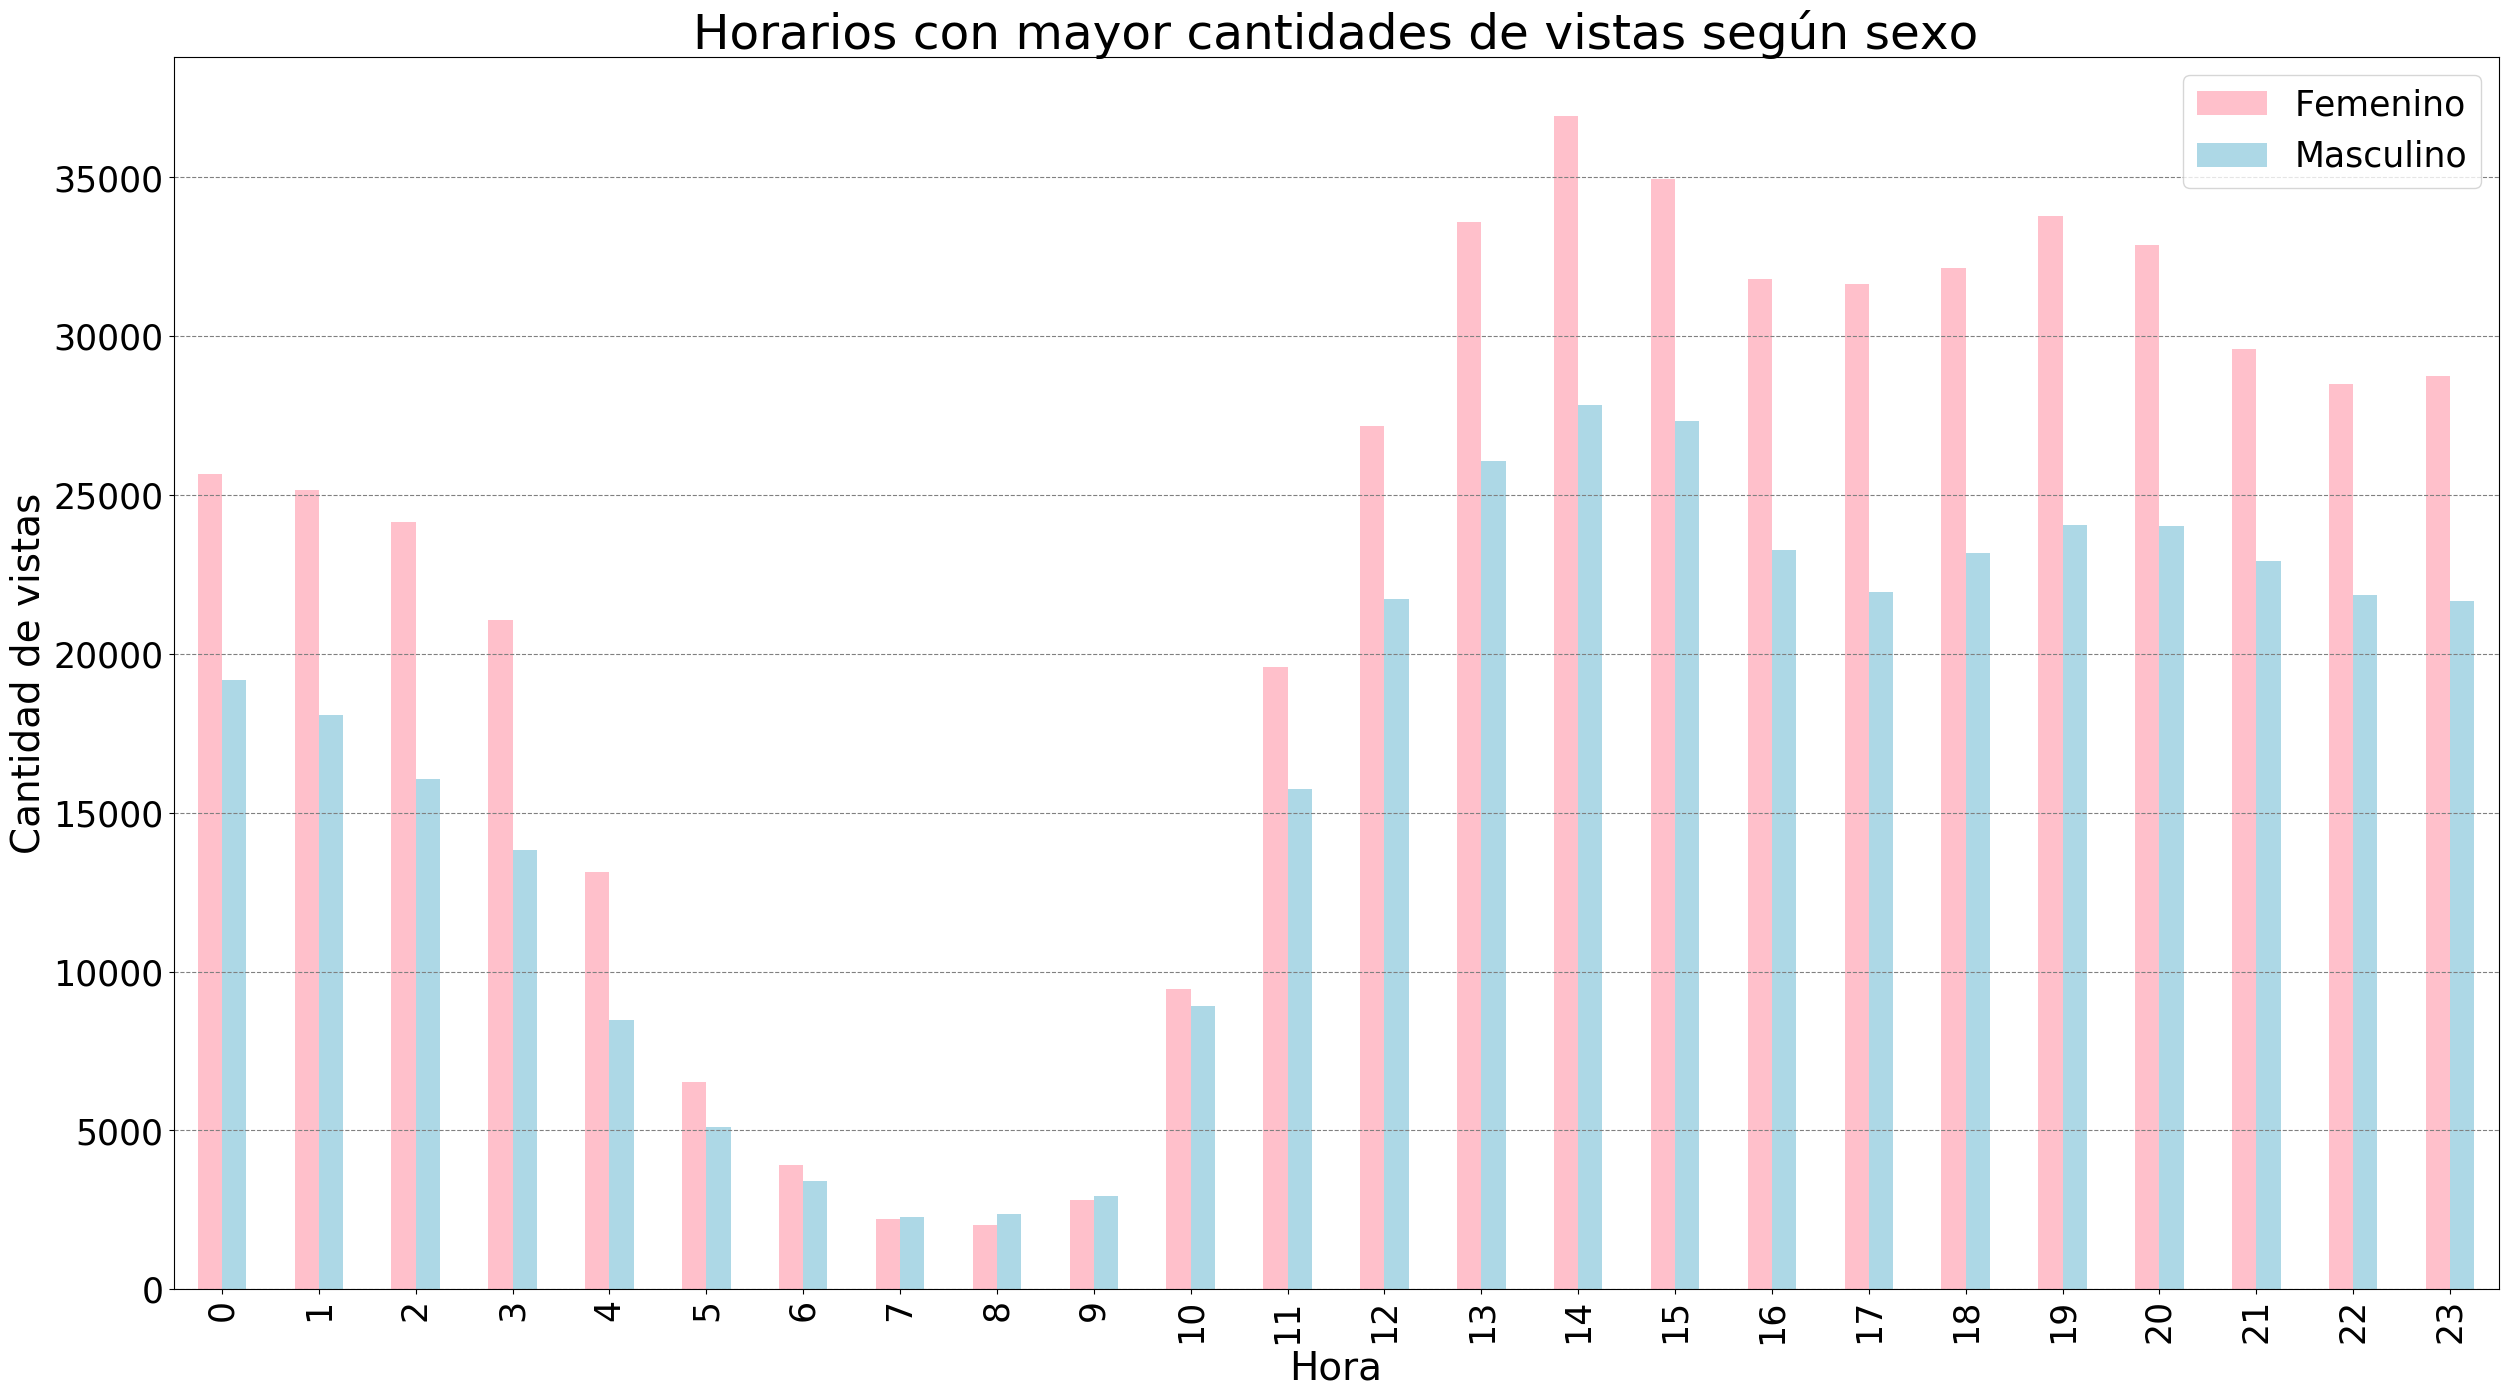

In [50]:
plt = vis_avi.loc[vis_avi.sexo != 'No declara',:]\
    .groupby(['hora','sexo']).size().to_frame('cant').reset_index()\
    .pivot(index='hora',columns='sexo',values='cant')

plt = plt.plot(kind = 'bar', color = ['pink','lightblue'],\
               figsize = (30, 16), fontsize = 25)
plt.set_xlabel('Hora', fontsize = 28)
plt.set_ylabel('Cantidad de vistas', fontsize = 28)
plt.set_title('Horarios con mayor cantidades de vistas según sexo', fontsize = 35)
plt.legend(fontsize = 25)
plt.grid(linestyle='dashed', color = 'gray')
plt.xaxis.grid(False);

En el único momento en el que hay mayor cantidad de vistas de postulantes de sexo masculino es entre las 7 y las 9 de la mañana, que es cuando menos vistas hay en general. En el resto de los horarios las vistas aumentan y siempre predominando la cantidad de vistas de postulantes mujeres.

In [51]:
def categorizar_edad(x):
    if (x <= 21):
        return '21 o menos'
    if (x <= 26):
        return '22 a 26'
    if (x <= 30):
        return '27 a 30'
    if (x <= 35):
        return '31 a 35'
    if (x <= 40):
        return '36 a 40'
    return '40 o más'

vis_avi['rango_edad2'] = vis_avi['edad'].apply(lambda x: categorizar_edad(x))

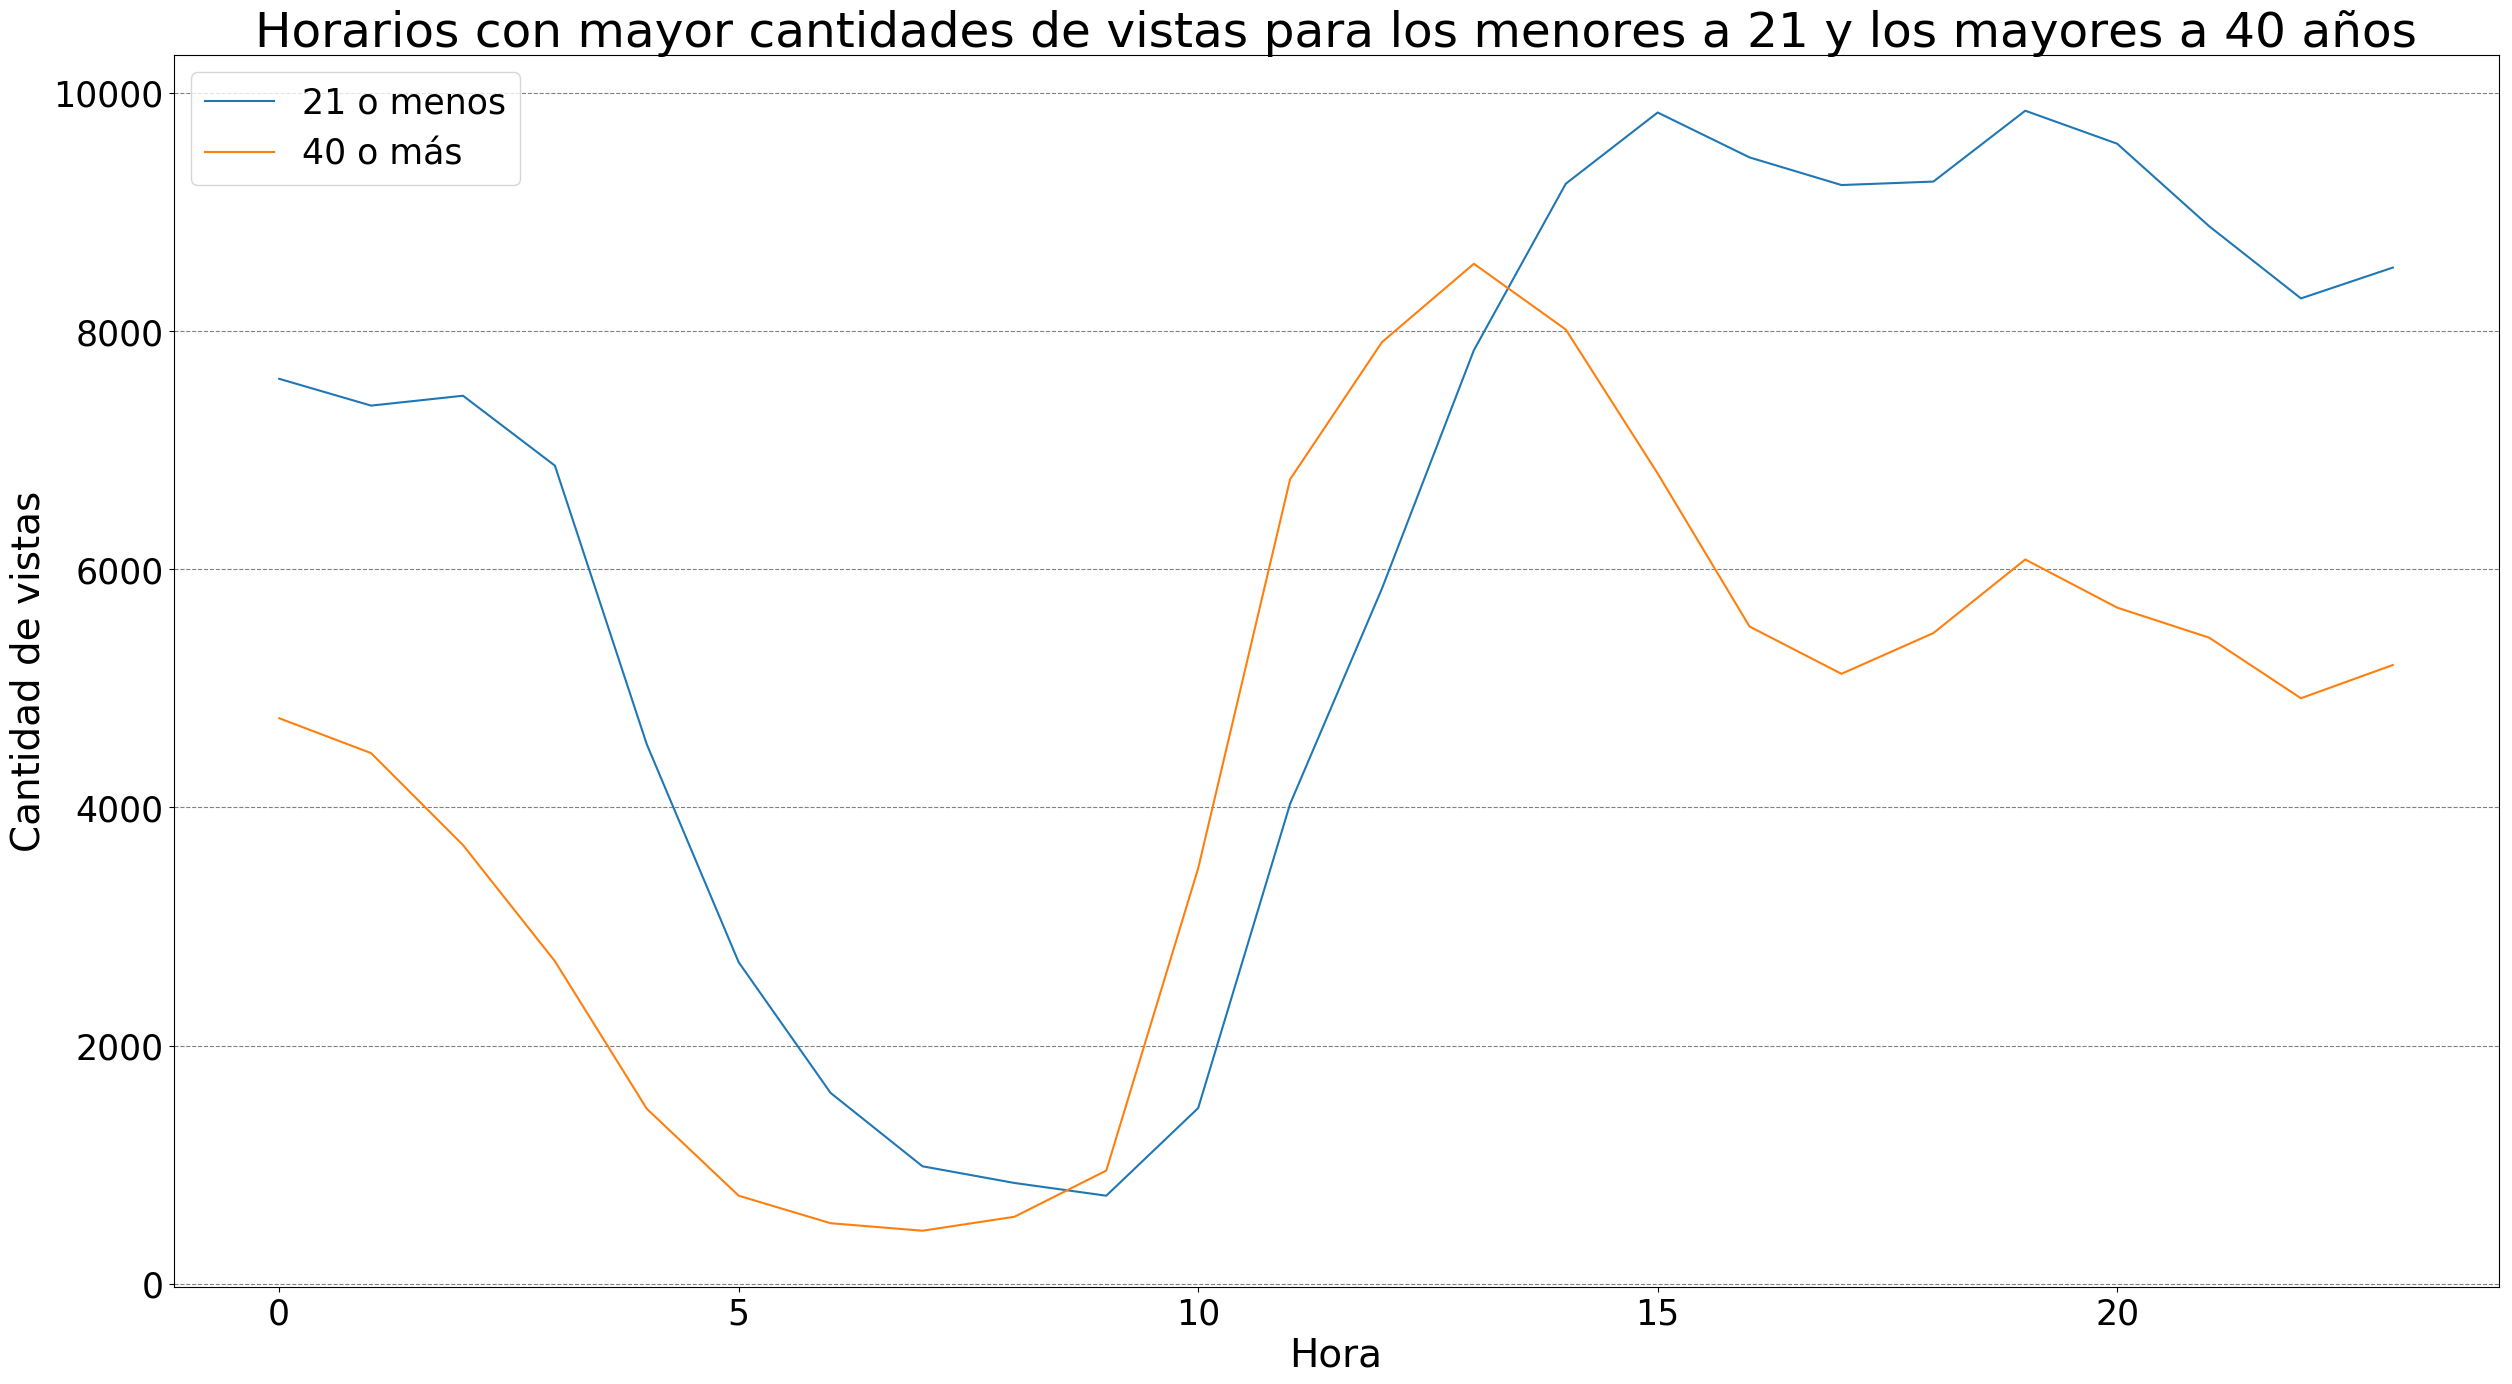

In [52]:
plt = vis_avi.loc[((vis_avi.rango_edad2 == '21 o menos')\
    | (vis_avi.rango_edad2 == '40 o más')),:]\
    .groupby(['hora','rango_edad2']).size().to_frame('cant').reset_index()\
    .pivot(index = 'hora', columns = 'rango_edad2', values = 'cant')

plt = plt.plot(figsize = (30, 16), fontsize = 25)
plt.set_xlabel('Hora', fontsize = 28)
plt.set_ylabel('Cantidad de vistas', fontsize = 28)
plt.set_title('Horarios con mayor cantidades de vistas' 
    + 'para los menores de 21 y los mayores de 40 años', fontsize = 35)
plt.legend(fontsize = 25)
plt.grid(linestyle='dashed', color = 'gray')
plt.xaxis.grid(False);

Por la mañana es cuando menos vistas hay y es justamente el único período de tiempo en el que los postulantes de 40 años o más de edad realizan más vistas que los de 21 años o menos (entre las 9 de la mañana y las 12 del mediodía). En todo otro momento predominan las vistas de los postulantes más jóvenes, incrementando la diferencia por la noche.

### Rangos horarios con más postulaciones

In [53]:
postulaciones['hora'] = postulaciones['fechapostulacion'].dt.hour
postulaciones.head()

,idaviso,idpostulante,fechapostulacion,num_dia,num_mes,num_semana,hora
0,1112257047,NM5M,2018-01-15 16:22:34,0,1,3,16
1,1111920714,NM5M,2018-02-06 09:04:50,1,2,6,9
2,1112346945,NM5M,2018-02-22 09:04:47,3,2,8,9
3,1112345547,NM5M,2018-02-22 09:04:59,3,2,8,9
4,1112237522,5awk,2018-01-25 18:55:03,3,1,4,18


In [54]:
#postulaciones = pd.merge(vistas, avisos_detalle, on='idaviso', how='inner')
postulaciones_det = pd.merge(postulaciones, postulantes,\
    on = 'idpostulante', how = 'inner')
postulaciones_det.head()

,idaviso,idpostulante,fechapostulacion,num_dia,num_mes,num_semana,hora,fechanacimiento,sexo,edad,nombre,estado,nivel_alcanzado,rango_edad
0,1112257047,NM5M,2018-01-15 16:22:34,0,1,3,16,1970-12-03,Femenino,47,Secundario,Graduado,1.0,41 a 50
1,1111920714,NM5M,2018-02-06 09:04:50,1,2,6,9,1970-12-03,Femenino,47,Secundario,Graduado,1.0,41 a 50
2,1112346945,NM5M,2018-02-22 09:04:47,3,2,8,9,1970-12-03,Femenino,47,Secundario,Graduado,1.0,41 a 50
3,1112345547,NM5M,2018-02-22 09:04:59,3,2,8,9,1970-12-03,Femenino,47,Secundario,Graduado,1.0,41 a 50
4,1112237522,5awk,2018-01-25 18:55:03,3,1,4,18,1962-12-04,Femenino,55,Universitario,Graduado,3.0,51 o más


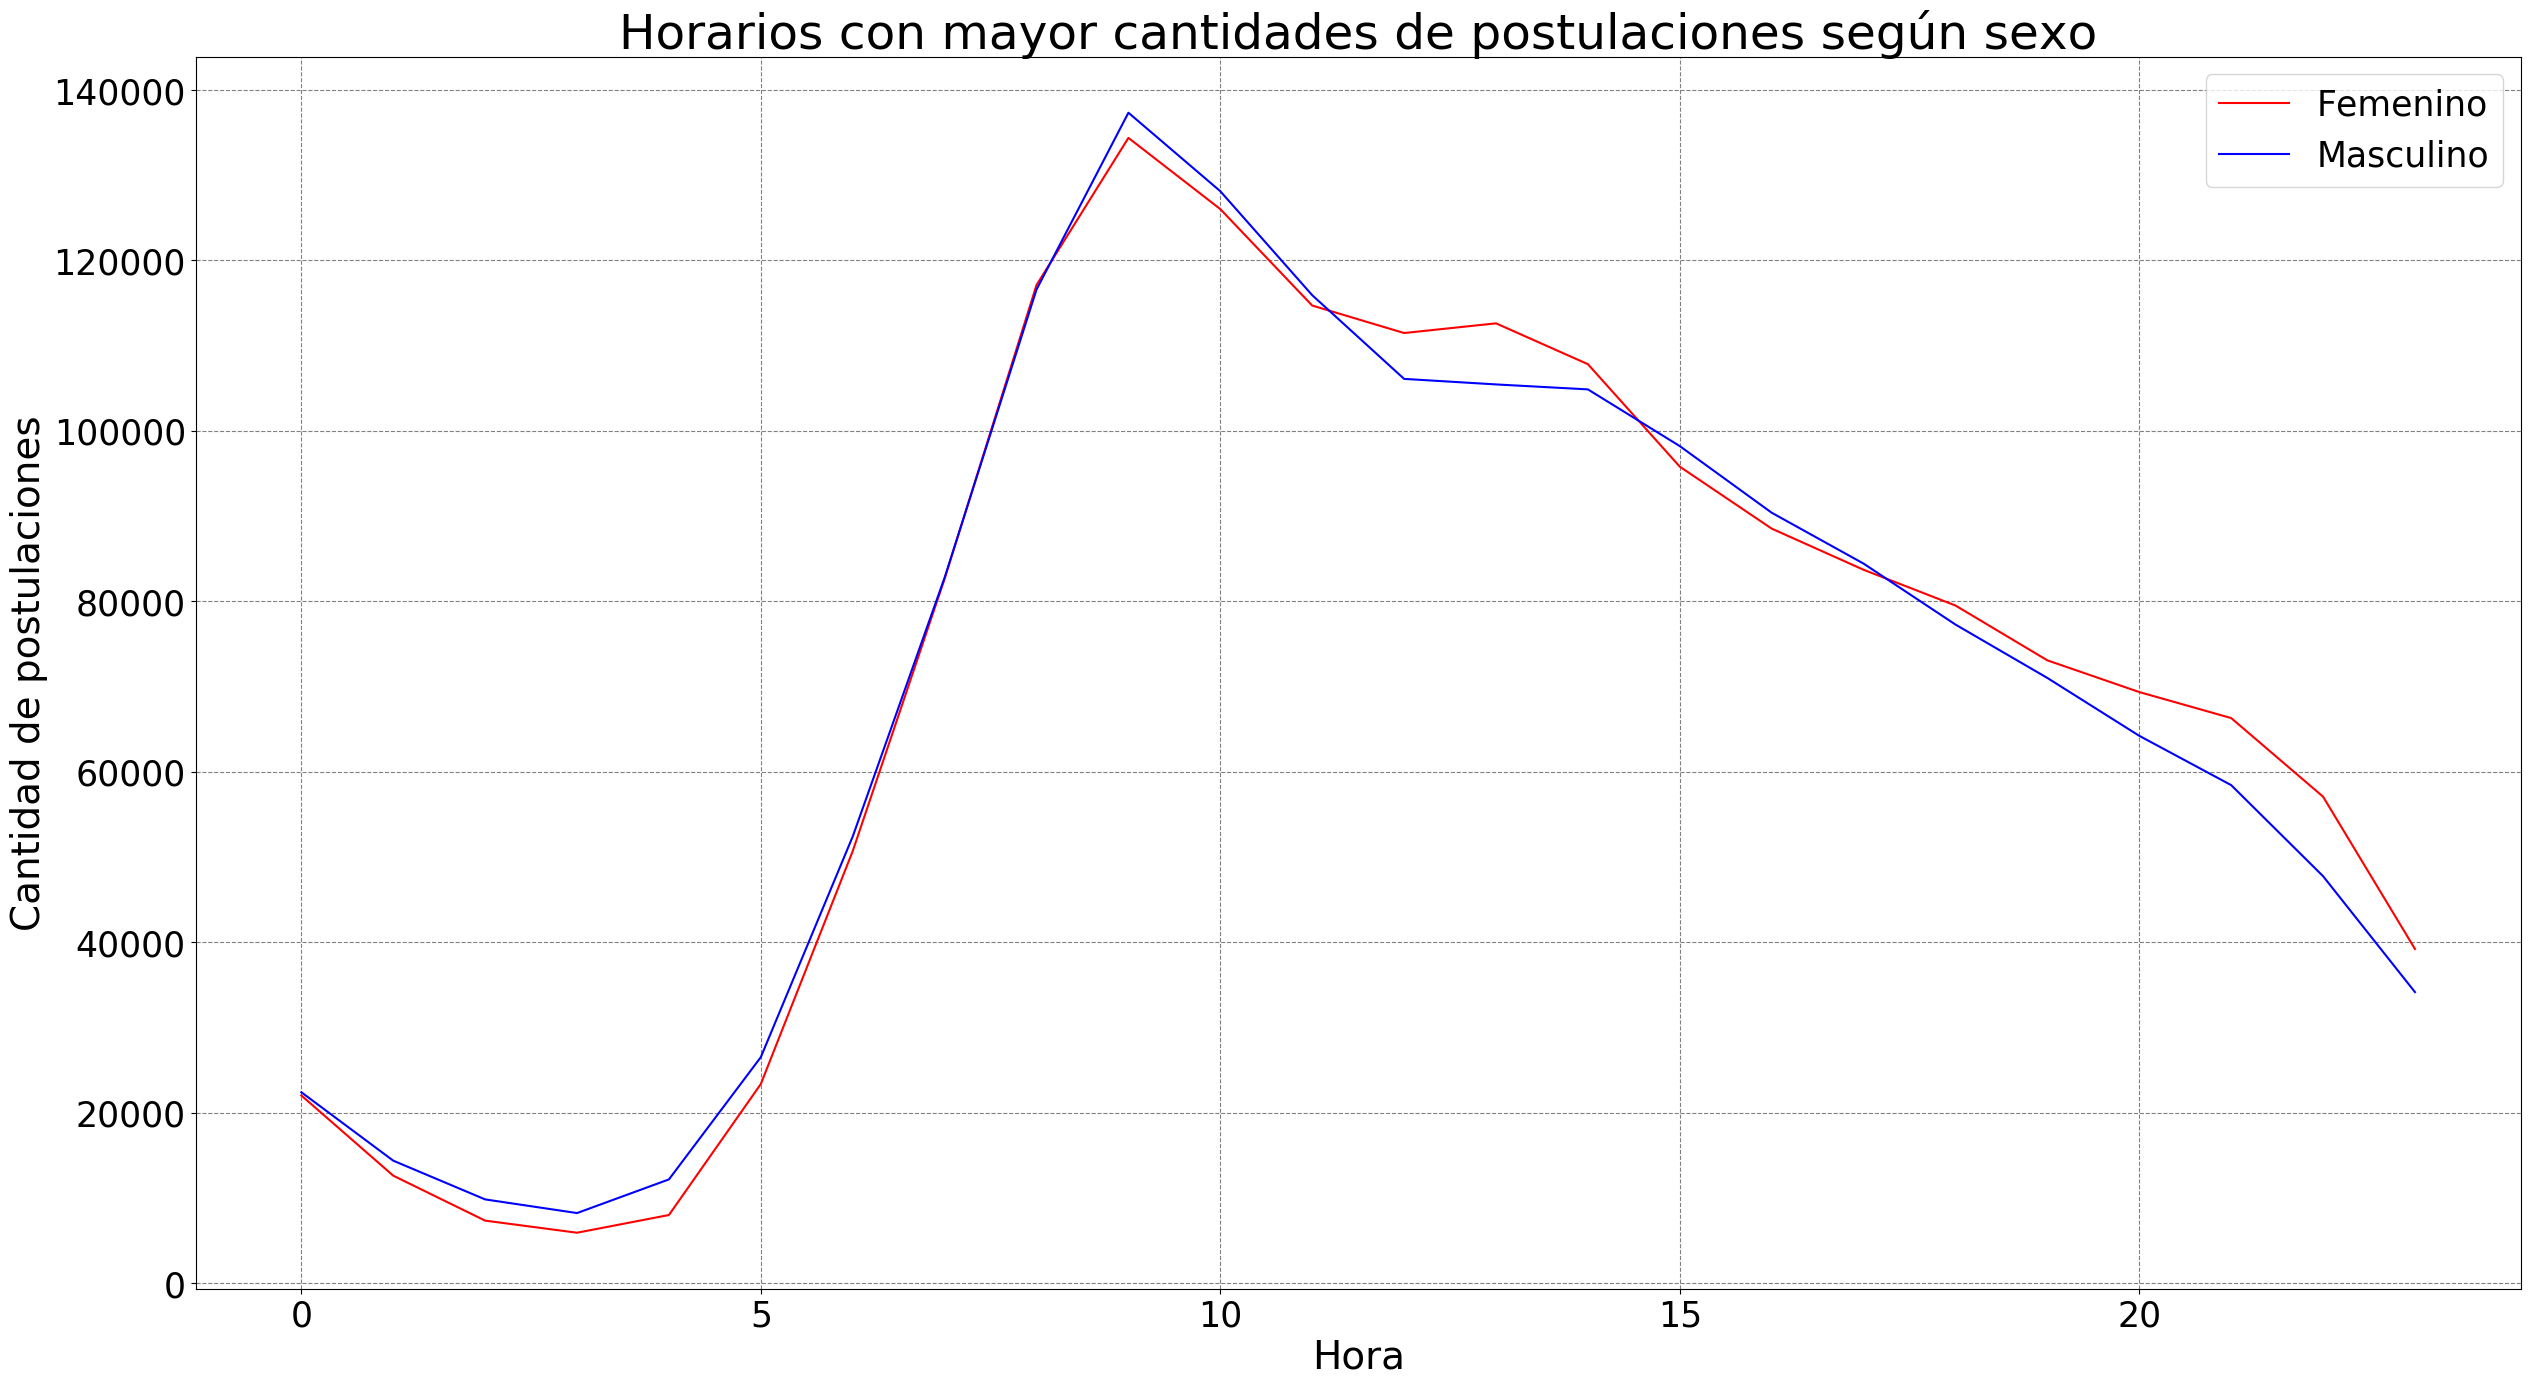

In [232]:
plt = postulaciones_det.loc[postulaciones_det.sexo != 'No declara',:]\
    .groupby(['hora','sexo']).size().to_frame('cant').reset_index()\
    .pivot(index='hora',columns='sexo',values='cant')

plt = plt.plot(color = ['r','b'], figsize = (30, 16), fontsize = 25)
plt.set_xlabel('Hora', fontsize = 28)
plt.set_ylabel('Cantidad de postulaciones', fontsize = 28)
plt.set_title('Horarios con mayor cantidades de postulaciones según sexo', fontsize = 35)
plt.legend(fontsize = 25)
plt.grid(linestyle='dashed', color = 'gray');

#### Horarios con más postulaciones por rango de edad

In [56]:
def categorizar_edad(x):
    if (x <= 21):
        return '< 21'
    if (x <= 26):
        return '22 a 26'
    if (x <= 30):
        return '27 a 30'
    if (x <= 35):
        return '31 a 35'
    if (x <= 40):
        return '36 a 40'
    return '> 40'

postulaciones_det['rango_edad2'] = postulaciones_det['edad'].apply(lambda x: categorizar_edad(x))

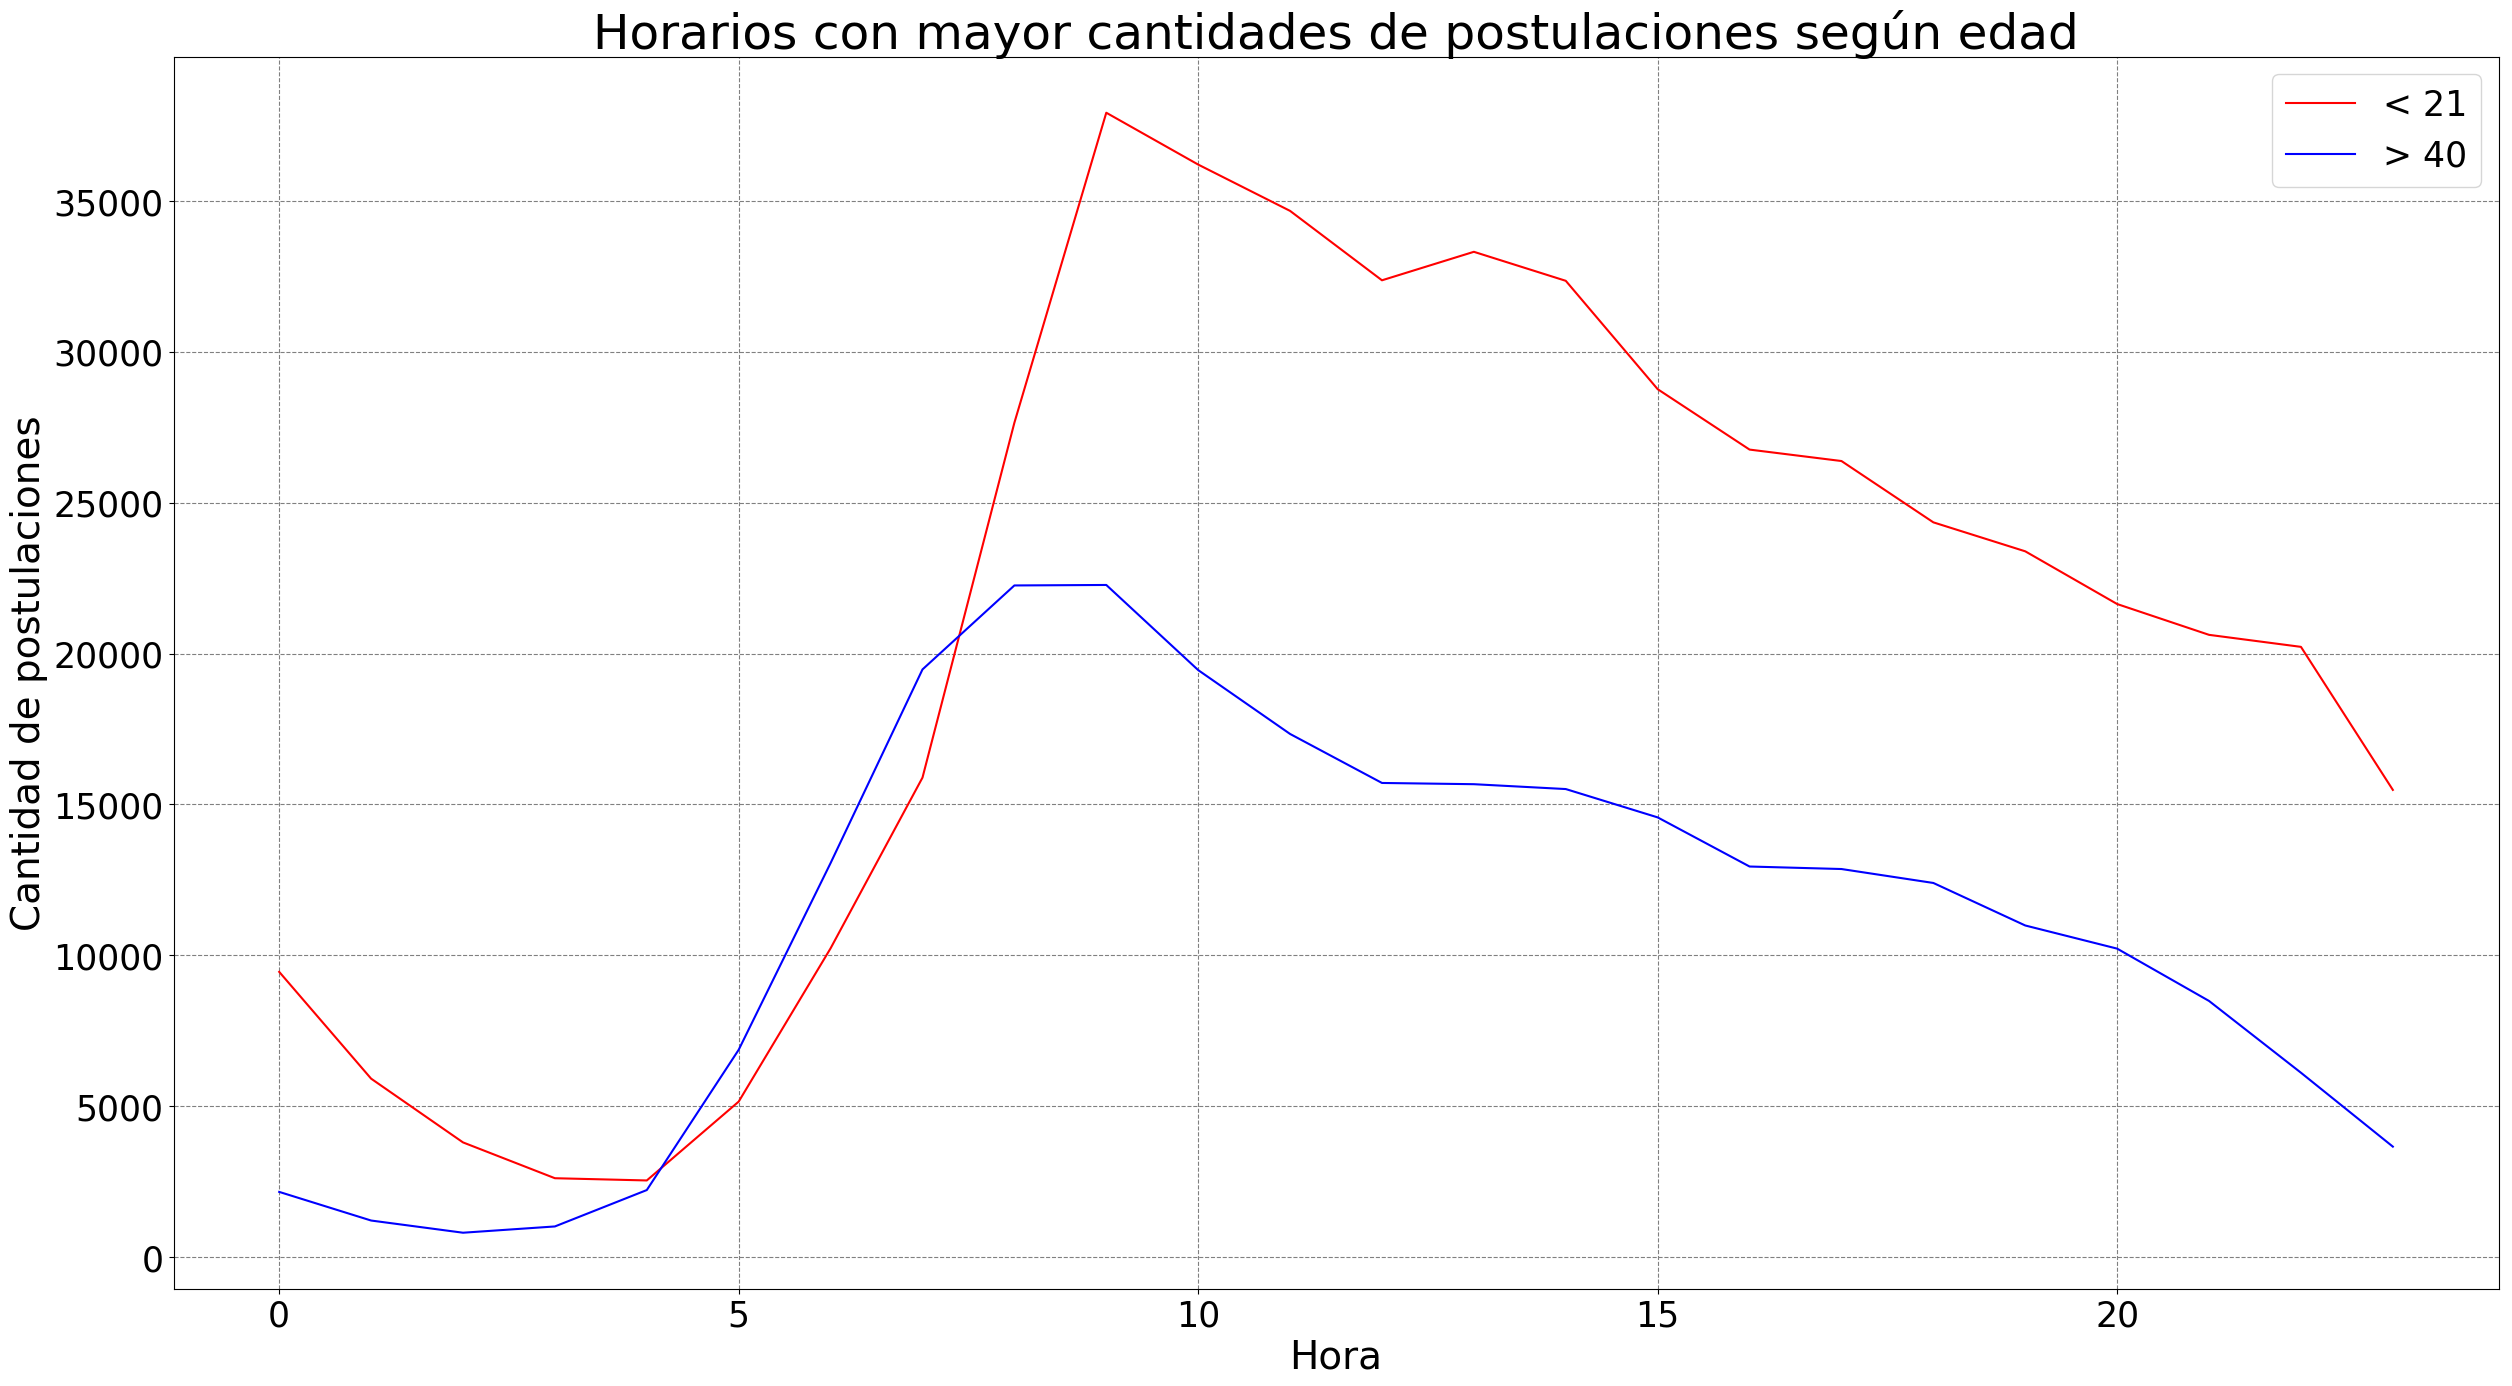

In [233]:
plt = postulaciones_det.loc[((postulaciones_det.rango_edad2 == '< 21') | (postulaciones_det.rango_edad2 == '> 40')),:]\
    .groupby(['hora','rango_edad2']).size().to_frame('cant').reset_index()\
    .pivot(index='hora',columns='rango_edad2',values='cant')
    
plt = plt.plot(color = ['r','b'], figsize = (30, 16), fontsize = 25)
plt.set_xlabel('Hora', fontsize = 28)
plt.set_ylabel('Cantidad de postulaciones', fontsize = 28)
plt.set_title('Horarios con mayor cantidades de postulaciones según edad', fontsize = 35)
plt.legend(fontsize = 25)
plt.grid(linestyle='dashed', color = 'gray');

En el gráfico anterior visualizamos únicamente las postulaciones para los rangos de edades mayores a 21 y menores a 40. Para poder visualizar todos los rangos juntos utilizaremos un mapa de calor:

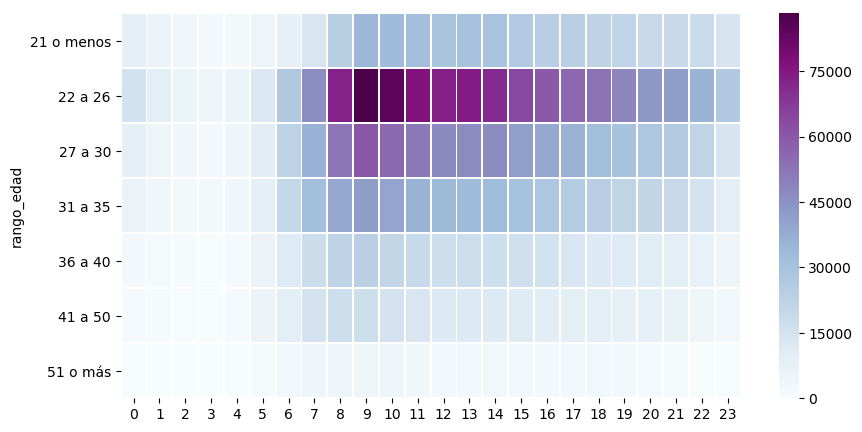

In [58]:
post_edad_hora = postulaciones_det.loc[(postulaciones_det.edad >=18) & (postulaciones_det.edad <=70) ,:]\
    .groupby(['hora','rango_edad']).size().to_frame('cant').reset_index()\
    .pivot(index='rango_edad',columns='hora',values='cant')
post_edad_hora = post_edad_hora.reset_index().rename_axis(None, axis=1)
post_edad_hora.set_index('rango_edad', inplace=True)
post_edad_hora.fillna(0,inplace=True)
sns.heatmap(post_edad_hora, cmap='BuPu', vmin=0, linewidths=0.5, annot=False);


Con esta visualización podemos apreciar que la hora con más postulaciones es las 9 de la mañana y que los rangos de edades más elevados tienen proporcionalmente más postulaciones más temprano comparado con los postulantes más jóvenes. Los que más realizan postulaciones a la medianoche son los menores de 26 años.

### Comparación entre áreas de trabajo de vistas y de postulaciones

In [60]:
df = pd.merge(postulaciones, avisos_detalle,on='idaviso', how='inner')

In [61]:
test2 = df.groupby('nombre_area').size().to_frame('cant')

In [62]:
test1.reset_index(inplace=True)
test2.reset_index(inplace=True)

In [63]:
test = pd.merge(test1, test2, on='nombre_area', how='inner')
test.set_index('nombre_area', inplace=True)

,cant_x,cant_y
nombre_area,,
Ventas,1659,408148
Comercial,983,216677
Administración,901,291135
Producción,821,277089
Programación,576,8188


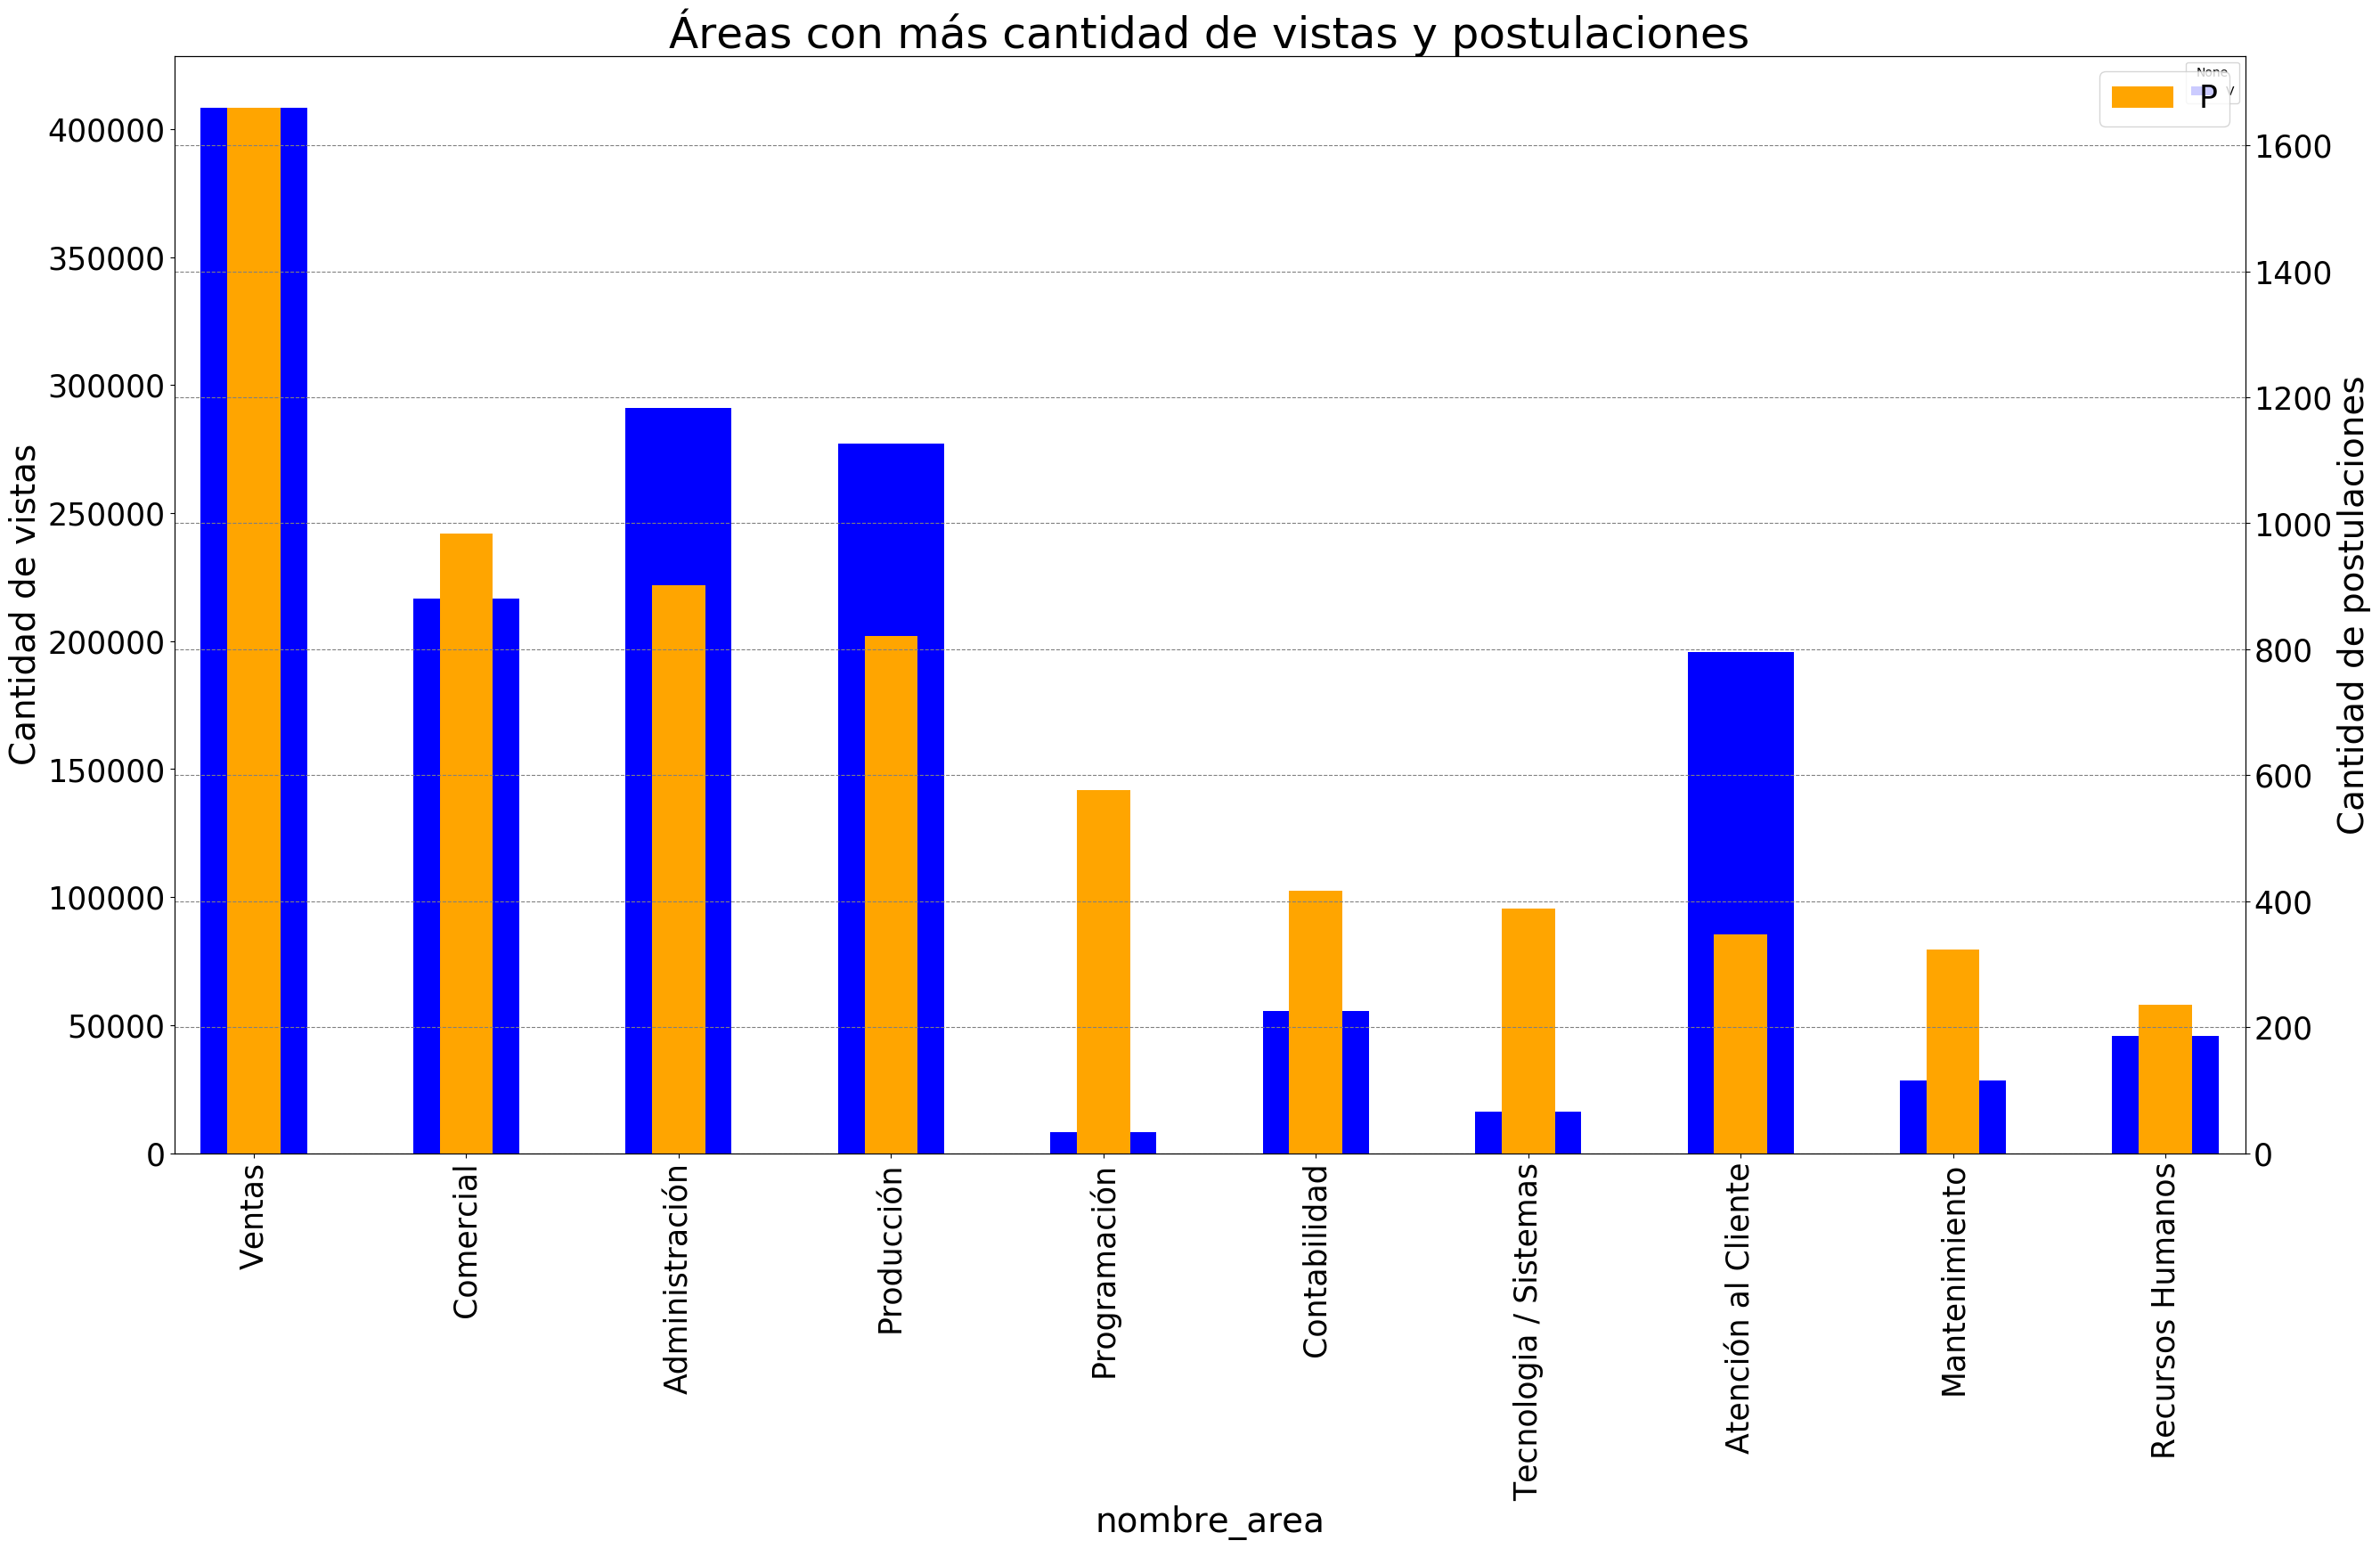

In [242]:
width = 0.5
plt1 = test.head(10)['cant_x'];
plt2 = test.head(10)['cant_y'].plot.bar(color='Blue', width = width);
plt2.set_ylabel('Cantidad de vistas', fontsize = 28)
plt2.set_xlabel('Áreas de trabajo', fontsize = 28)
plt2.legend("Vistas", fontsize = 25)
plt = plt1.plot.bar(color = 'Orange',ax=plt2,secondary_y=True,\
                    width = width/2,figsize = (30, 16), fontsize = 25)

plt.set_xlabel('Áreas de trabajo', fontsize = 28)
plt.set_ylabel('Cantidad de postulaciones', fontsize = 28)
plt.set_title('Áreas con más cantidad de vistas y postulaciones', fontsize = 35)
plt.grid(linestyle = 'dashed', color = 'gray')
plt.xaxis.grid(False)
plt.legend("Postulaciones", fontsize = 25);

### Variedad de las áreas de trabajo a las que se postulan

En esta parte, nos interesa conocer para cada postulante, la cantidad de avisos de distinto tipo se postuló, para asi poder visualizar como varía respecto a la edad del postulante

In [69]:
postulante_aviso = pd.merge(postulaciones, avisos_detalle,on='idaviso', how='inner')

In [70]:
variedad_por_postulante = postulante_aviso.groupby(['idpostulante','nombre_area'])\
    .size().to_frame('cant').reset_index()
postulante_postulaciones = pd.merge(postulantes, variedad_por_postulante,\
                                    on = 'idpostulante', how = 'inner')
postulante_postulaciones = postulante_postulaciones.loc[postulante_postulaciones['edad'] <= 62,:]

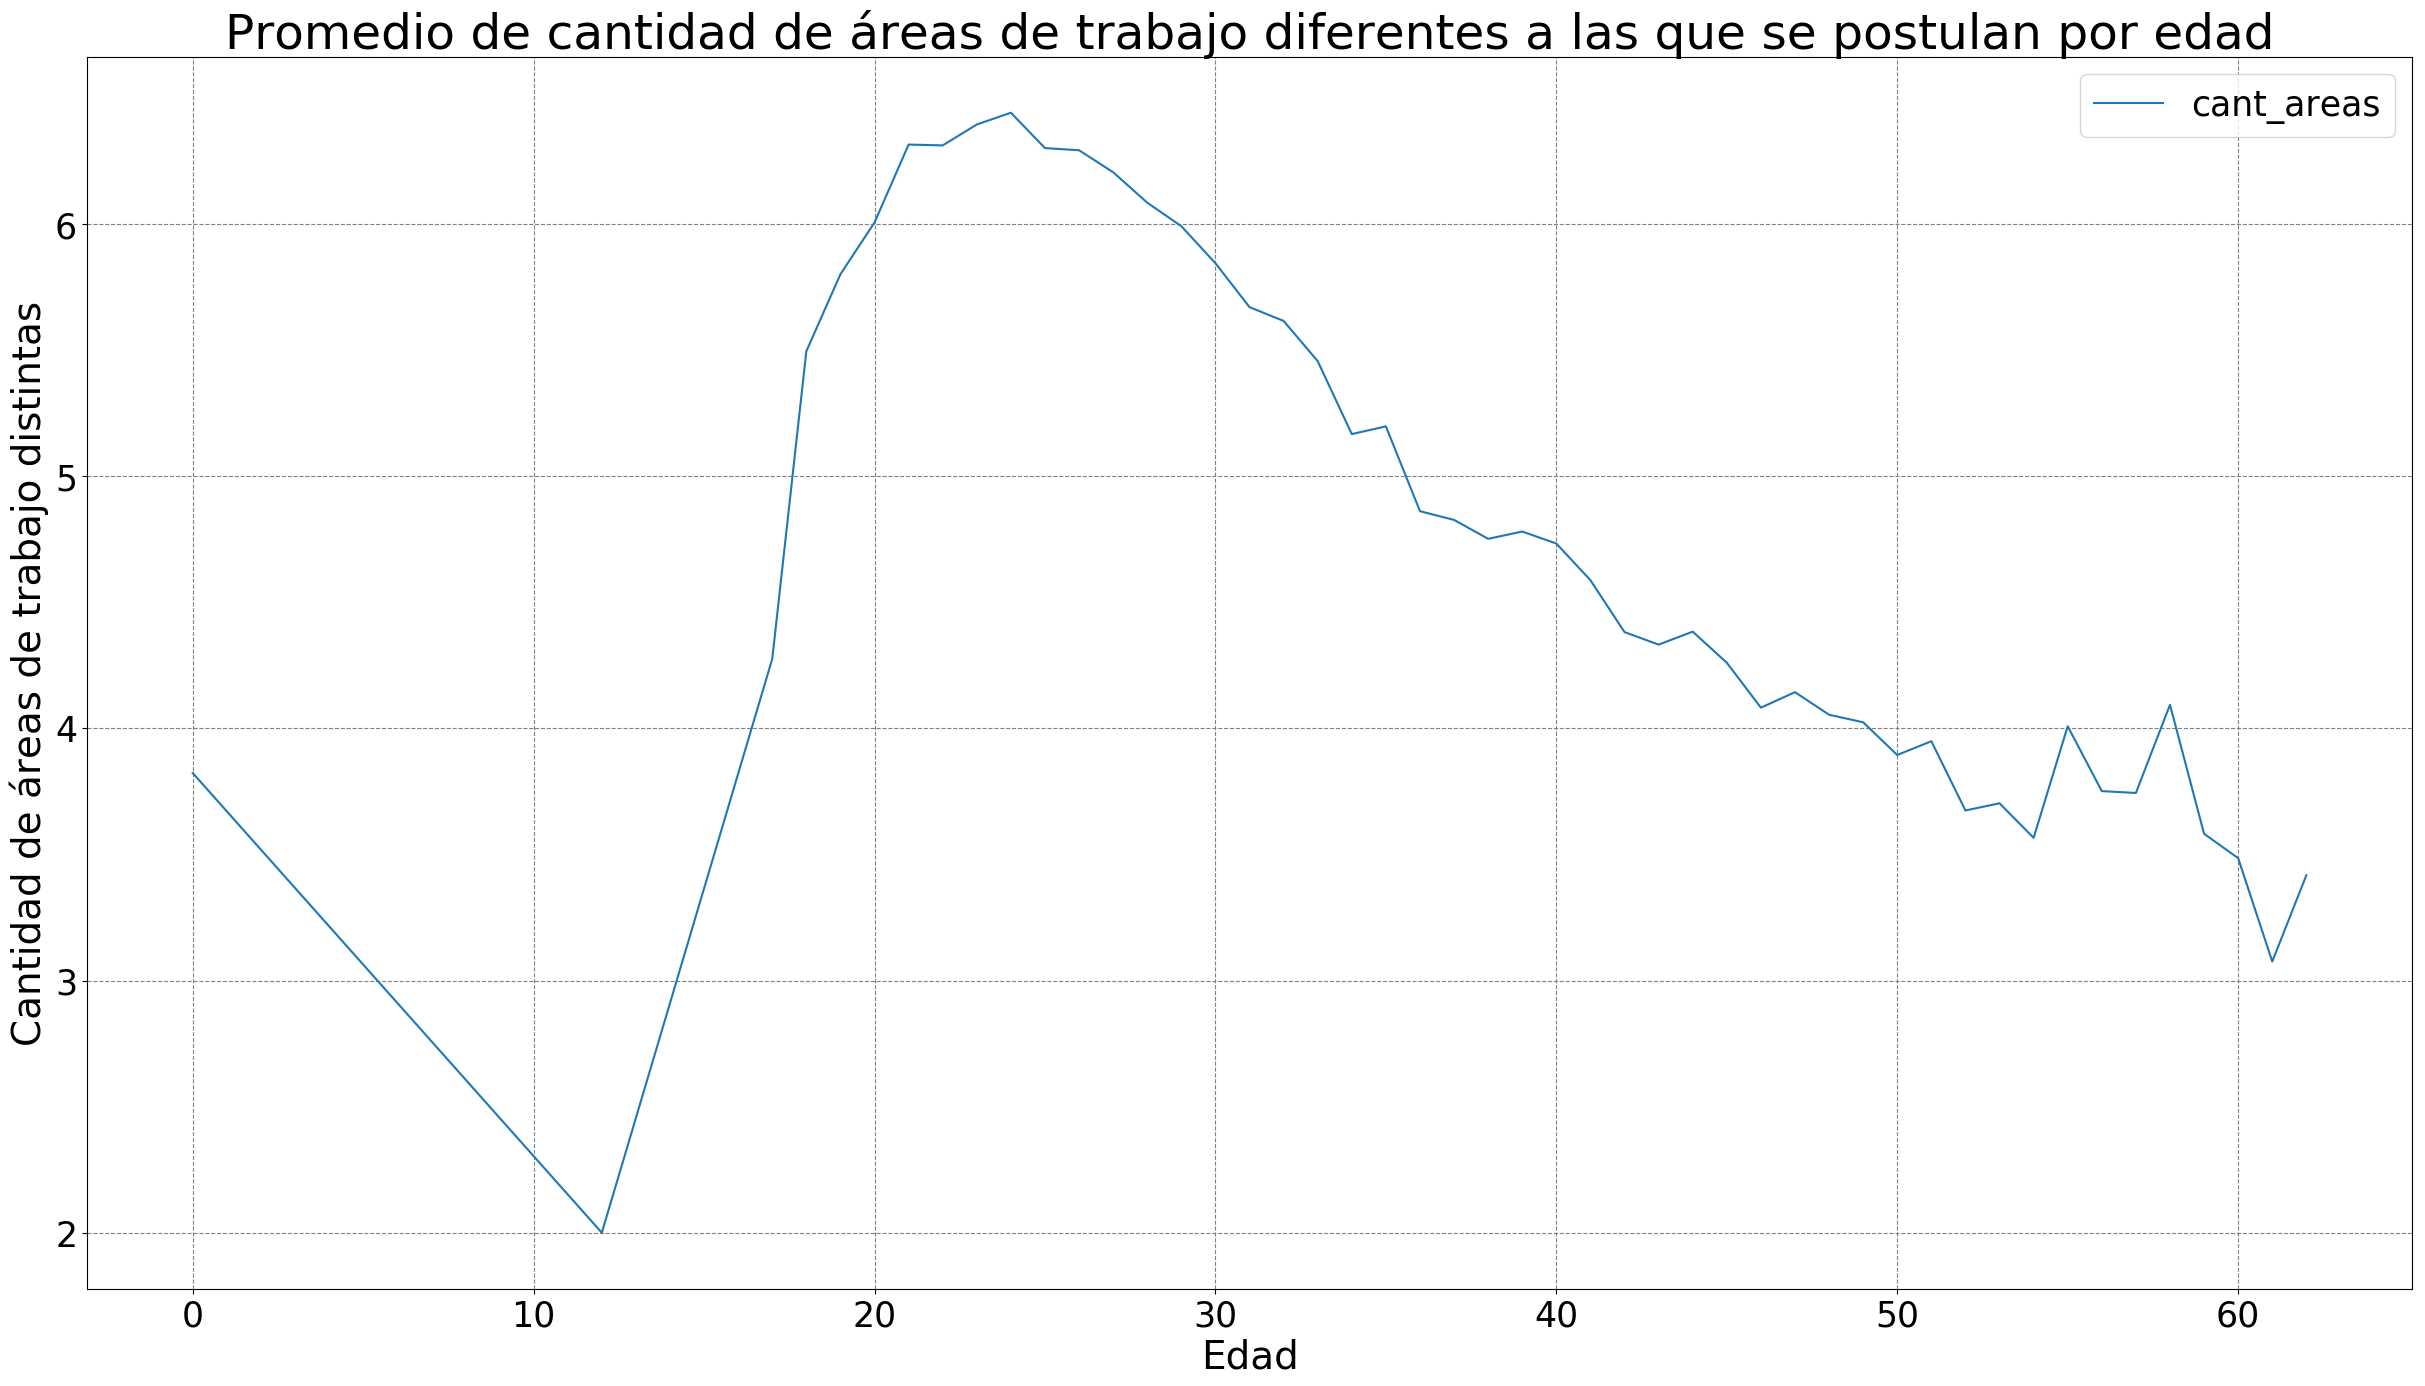

In [72]:
areas_x_edad = postulante_postulaciones.groupby(['edad','idpostulante'])\
    .size().to_frame('cant_areas').reset_index()
areas_x_edad = areas_x_edad.groupby('edad')['cant_areas'].mean().to_frame()

plt = areas_x_edad.plot(figsize = (30, 16), fontsize = 25)
plt.set_xlabel('Edad', fontsize = 28)
plt.set_ylabel('Cantidad de áreas de trabajo distintas', fontsize = 28)
plt.set_title('Promedio de cantidad de áreas diferentes a las que se postulan por edad', fontsize = 35)
plt.legend(fontsize = 25)
plt.grid(linestyle='dashed', color = 'gray');

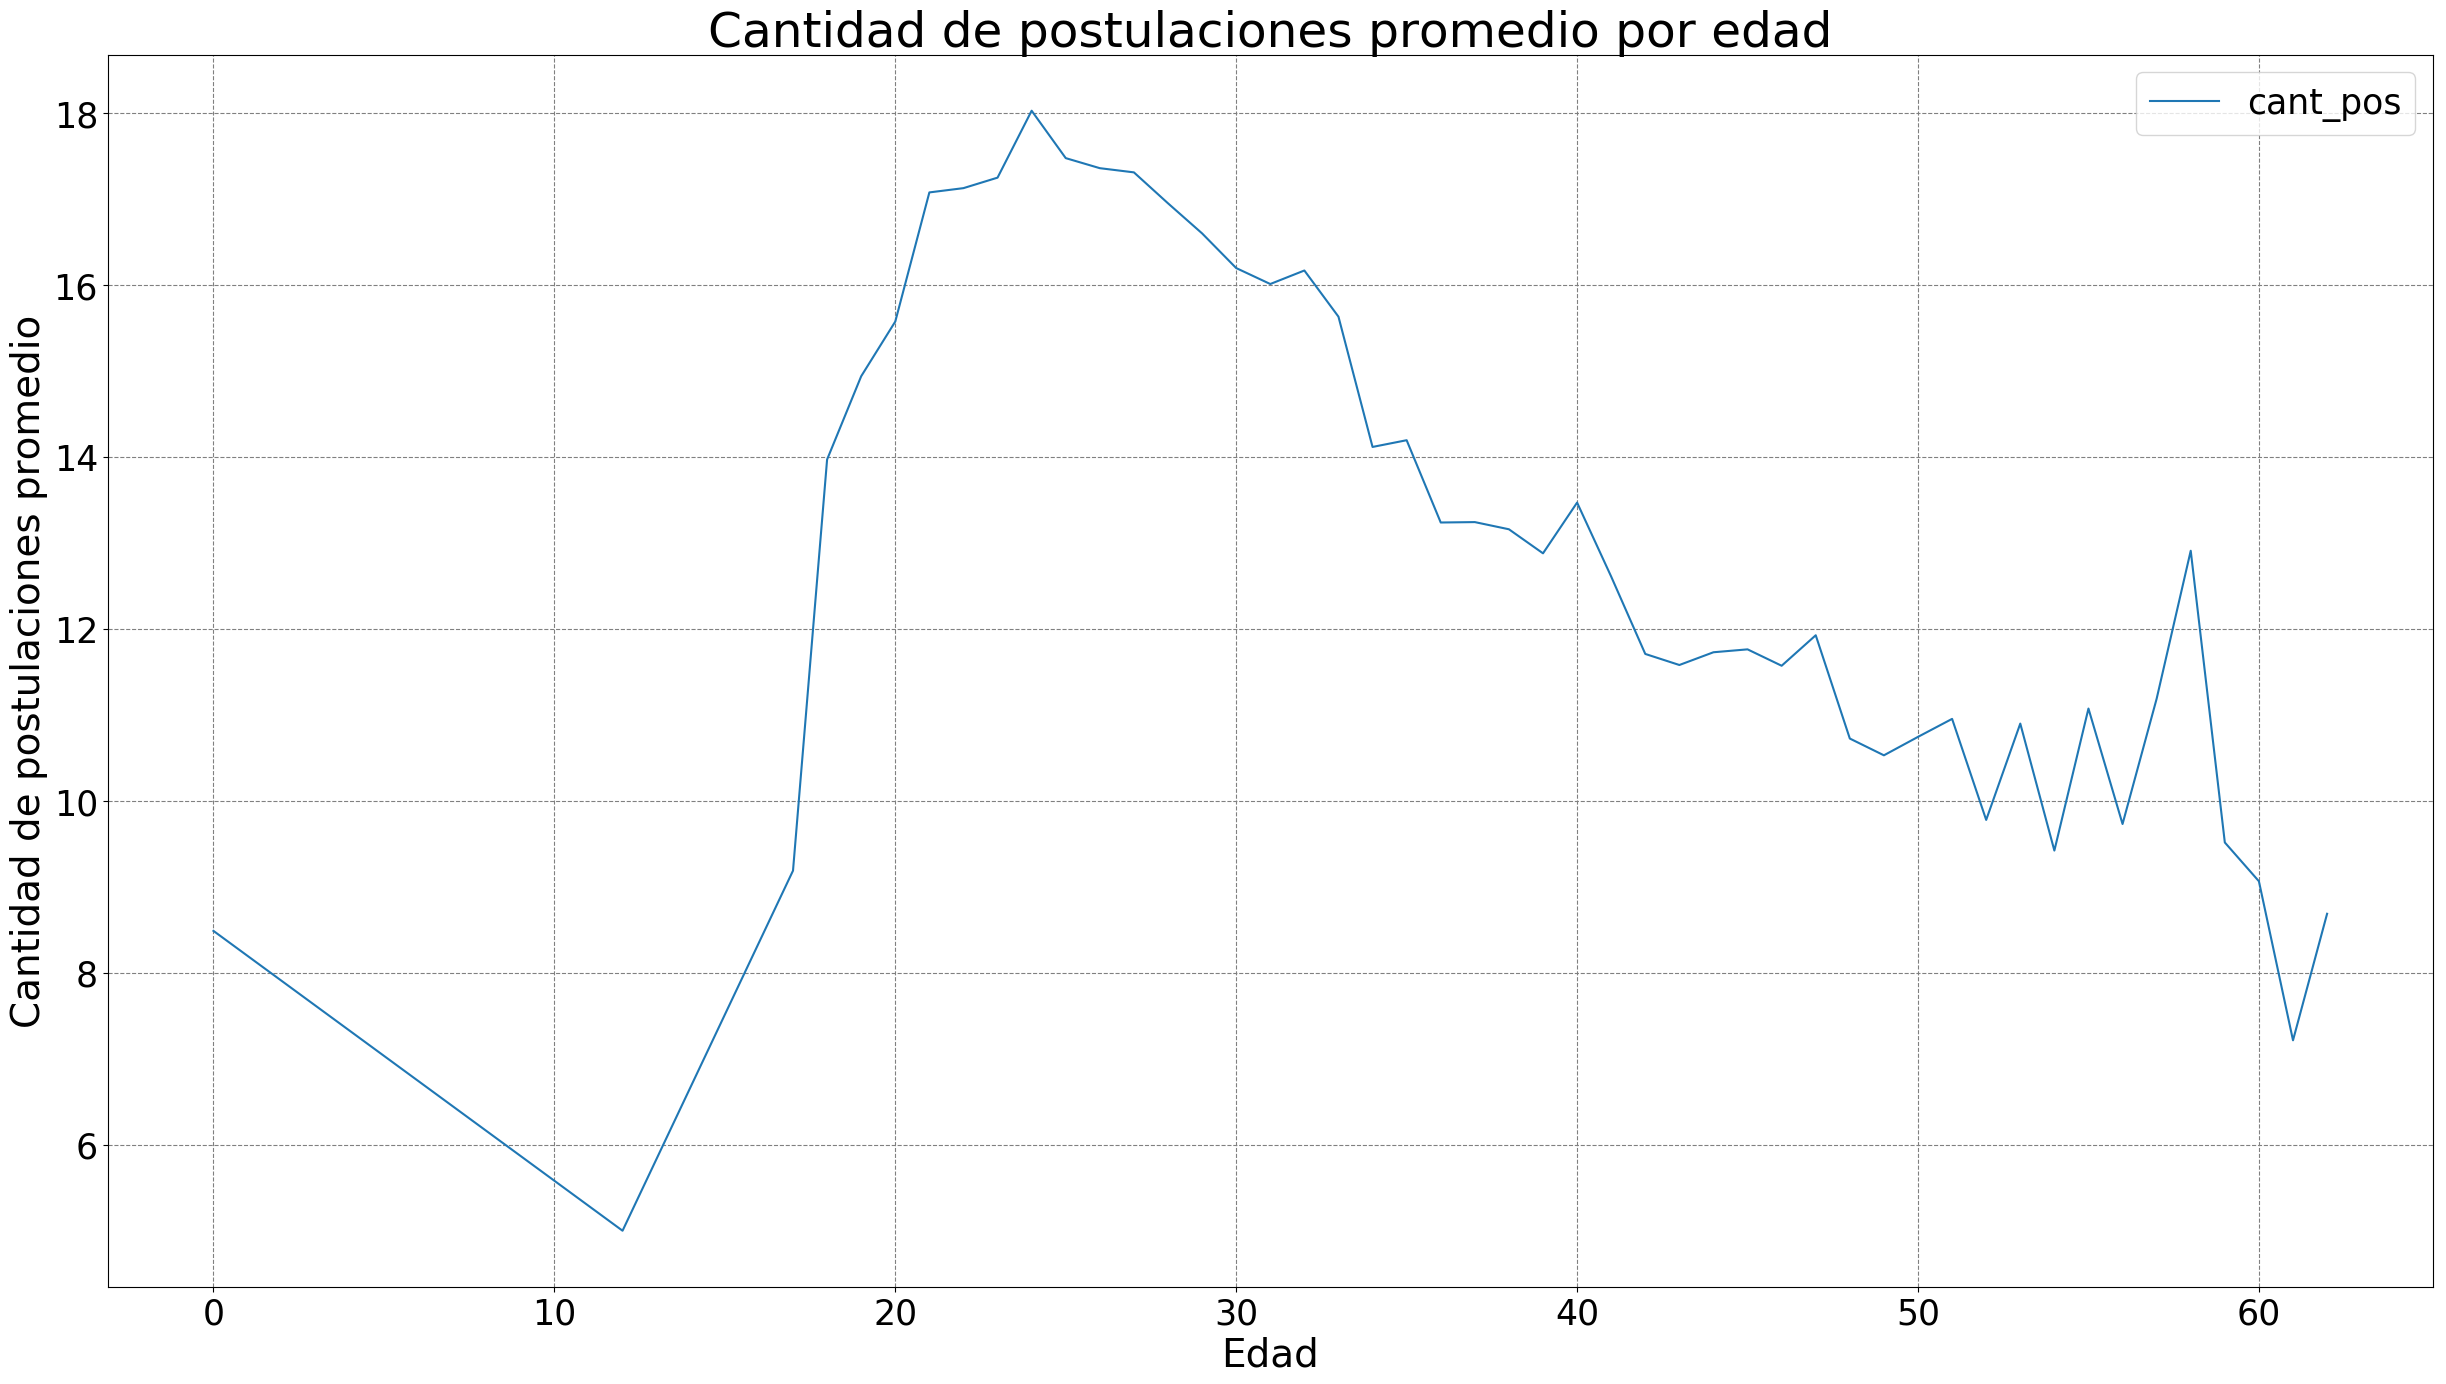

In [73]:
cantidad_por_postulante = postulante_aviso.groupby('idpostulante').size()\
    .to_frame('cant_pos').reset_index()
cantidad_por_postulante = pd.merge(postulantes, cantidad_por_postulante,\
                                   on = 'idpostulante',how= 'inner')
cantidad_por_postulante = cantidad_por_postulante.loc[cantidad_por_postulante['edad'] <= 62,:]
cantidad_x_edad = cantidad_por_postulante.groupby('edad')['cant_pos'].mean()

plt = cantidad_x_edad.to_frame().plot(figsize = (30, 16), fontsize = 25)
plt.set_xlabel('Edad', fontsize = 28)
plt.set_ylabel('Cantidad de postulaciones promedio', fontsize = 28)
plt.set_title('Cantidad de postulaciones promedio por edad', fontsize = 35)
plt.legend(fontsize = 25)
plt.grid(linestyle='dashed', color = 'gray');

### Sexo predominante por área de trabajo

In [243]:
areas_x_sexo = postulante_postulaciones.groupby(['nombre_area','sexo']).size().to_frame('cant')\
    .reset_index().pivot(index='nombre_area', columns='sexo', values='cant').reset_index()
areas_x_sexo.fillna(0,inplace=True)
def restar(x):
    return abs(x.Femenino - x.Masculino)
def sumar(x):
    return (x.Femenino + x.Masculino)
areas_x_sexo['diferencia'] = areas_x_sexo.apply(lambda x: restar(x),axis=1)
areas_x_sexo['total'] = areas_x_sexo.apply(lambda x: sumar(x),axis=1)
areas_x_sexo = areas_x_sexo.loc[areas_x_sexo['total'] >= 1500,:]
areas_x_sexo['porc_fem'] = (areas_x_sexo.Femenino / areas_x_sexo.total) * 100
areas_x_sexo['porc_masc'] = (areas_x_sexo.Masculino / areas_x_sexo.total) * 100

In [244]:
def sexo_pred(x):
    if(x.porc_fem > x.porc_masc):
        return 'Femenino'
    if(x.porc_fem < x.porc_masc):
        return 'Masculino'
    
areas_x_sexo['sexo_pred'] = areas_x_sexo.apply(lambda x : sexo_pred(x), axis = 1)
areas_x_sexo = areas_x_sexo.loc[(areas_x_sexo.diferencia/areas_x_sexo.total *100) >= 40,:]\
    .sort_values('diferencia',ascending=False)
areas_x_sexo = areas_x_sexo.reset_index(drop=True).rename_axis(None, axis=1)

In [ ]:
porc_color = OrderedDict([
    ("Masculino",   "#abb2ce"),
    ("Femenino", "#f79774")
    ])

sex_color = {
    "Masculino" : "#C4C9DC",
    "Femenino" : "#f9b49a",
    }

width = 1000
height = 1000
inner_radius = 90
outer_radius = 290

minr = 0.0
maxr = 100.0

a = (outer_radius - inner_radius) / (maxr - minr)

def rad(mic):
    return   (a * mic) + inner_radius

big_angle = 2.0 * np.pi / (len(areas_x_sexo) + 1)
small_angle = big_angle / 7

p = figure(plot_width=width, plot_height=height, title="",
    x_axis_type=None, y_axis_type=None,
    x_range=(-420, 420), y_range=(-420, 420),
    min_border=0, outline_line_color="black",
    background_fill_color="#f0e1d2")

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

angles = np.pi/2 - big_angle/2 - areas_x_sexo.index.to_series()*big_angle
colors = [sex_color[sexo_pred] for sexo_pred in areas_x_sexo.sexo_pred]
p.annular_wedge(
    0, 0, inner_radius, outer_radius, -big_angle+angles, angles, color=colors,
)

p.annular_wedge(0, 0, inner_radius, rad(areas_x_sexo.porc_fem),
                -big_angle+angles+4*small_angle, -big_angle+angles+6*small_angle,
                color=porc_color['Femenino'])
p.annular_wedge(0, 0, inner_radius, rad(areas_x_sexo.porc_masc),
                -big_angle+angles+1*small_angle, -big_angle+angles+3*small_angle,
                color=porc_color['Masculino'])


labels = np.asarray([20.0,40.0,60.0,80.0,100.0])
radii = (a * labels) + inner_radius
p.circle(0, 0, radius=radii, fill_color=None, line_color="white")
p.text(0, radii[:-1], [str(r) for r in labels[:-1]],
       text_font_size="8pt", text_align="center", text_baseline="middle")

p.annular_wedge(0, 0, inner_radius-10, outer_radius+10,
                -big_angle+angles, -big_angle+angles, color="black")

xr = radii[0]*np.cos(np.array(-big_angle/2 + angles))
yr = radii[0]*np.sin(np.array(-big_angle/2 + angles))
label_angle=np.array(-big_angle/2+angles)
label_angle[label_angle < -np.pi/2] += np.pi
p.text(xr, yr, areas_x_sexo.nombre_area, angle=label_angle,
       text_font_size="9pt", text_align="center", text_baseline="middle")


p.circle([-40, -40], [-370, -390], color=list(sex_color.values()), radius=5)
p.text([-30, -30], [-370, -390], text=["" + gr for gr in sex_color.keys()],
       text_font_size="7pt", text_align="left", text_baseline="middle")

p.rect([-40, -40, -40], [18, 0, -18], width=30, height=13,
       color=list(porc_color.values()))
p.text([-15, -15, -15], [18, 0, -18], text=list(porc_color),
       text_font_size="9pt", text_align="left", text_baseline="middle")

output_file("areas_sexo.html")

show(p)

![Áreas por sexo](./areas_x_sexo.png)

Las áreas de trabajo a las que se postulan más mujeres que hombres son las de Recepcionista, Secretaria, Asistente y Salud. En todas las demás hay más postulantes hombres y esa diferencia se incrementa más en áreas de ingeniería, Mantenimiento, Transporte y Telecomunicaciones.